# Fine Mapping

I want to take the significant eQTL variants and functionally annotate them
to come up with a list of variants that might be causal. There is a lot of
functional data for the H1-hESC line that I can use along with data from
other places.

In [589]:
import copy
import cPickle
import glob
import os
import random
import re
import subprocess
import urllib2
import uuid

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pybedtools as pbt
import scipy
import scipy.stats as stats
import seaborn as sns
import tabix
import vcf as pyvcf

import cardipspy as cpy
import ciepy

%matplotlib inline

dy_name = 'fine_mapping'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
tg = pd.read_table(cpy.gencode_transcript_gene, index_col=0, 
                   header=None, squeeze=True)
gene_info = pd.read_table(cpy.gencode_gene_info, index_col=0)
transcript_to_gene = pd.read_table(cpy.gencode_transcript_gene, header=None, 
                                   squeeze=True, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'eqtl_input', 
                  'tpm_log_filtered_phe_std_norm_peer_resid.tsv')
exp = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'qvalues.tsv')
qvalues = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls02', 'qvalues.tsv')
secondary_qvalues = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'lead_variants_single.tsv')
lead_variants_single = pd.read_table(fn, index_col=0)
lead_variants_single_f = lead_variants_single[lead_variants_single.perm_sig]

genes = pbt.BedTool(cpy.gencode_gene_bed)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

fn = os.path.join(ciepy.root, 'output', 'eqtl_processing', 'eqtls01', 'gene_variant_pairs.tsv')
gene_variants = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis',
                  'encode_stem_cell_chip_seq.tsv')
encode_chip_seq = pd.read_table(fn, index_col=0)

ensg = pd.Series(gene_info.index, index=[x.split('.')[0] for x in gene_info.index])

fn = os.path.join(ciepy.root, 'output', 'cnv_analysis', 'cnv_gene_variants.pickle')
cnv_gv = pd.read_pickle(fn)

In [3]:
subject_meta = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'subject_metadata.tsv'), 
                             index_col=0)
rna_meta = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'rnaseq_metadata.tsv'), 
                         index_col=0)
wgs_meta = pd.read_table(os.path.join(ciepy.root, 'output', 'input_data', 'wgs_metadata.tsv'), 
                         index_col=0)

In [4]:
# ASE results.
fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_major_allele_freq.tsv')
maj_af = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'input_data', 
                  'mbased_p_val_ase.tsv')
ase_pval = pd.read_table(fn, index_col=0)

locus_p = pd.Panel({'major_allele_freq':maj_af, 'p_val_ase':ase_pval})
locus_p = locus_p.swapaxes(0, 2)

snv_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'mbased_snv',
                                 '*_snv.tsv'))
count_fns = glob.glob(os.path.join(ciepy.root, 'private_output', 'input_data', 'allele_counts',
                                   '*mbased_input.tsv'))

snv_res = {}
for fn in snv_fns:
    snv_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)
    
count_res = {}
for fn in count_fns:
    count_res[os.path.split(fn)[1].split('_')[0]] = pd.read_table(fn, index_col=0)

snv_p = pd.Panel(snv_res)

In [5]:
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'matrices.pickle')
with open(fn) as f:
    matrices = cPickle.load(f)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
motif_info_full = pd.read_table(fn, index_col=0)
motif_info_full['target'] = [x.split('_')[0] for x in motif_info_full.index]
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_full.tsv')
motif_info = pd.read_table(fn, index_col=0)
fn = os.path.join(ciepy.root, 'output', 'motif_search', 'motif_info_rep.tsv')
motif_info_rep = pd.read_table(fn, index_col=0)
motif_info['target'] = [x.split('_')[0] for x in motif_info.index]

I'll drop CNVs since they likely act through different mechanisms than I'm considering here.

In [6]:
n = gene_variants.shape[0]
print('{:,} total associations.'.format(n))
n = len(set(gene_variants.location))
print('{:,} total distinct SNV, indels, and CNVs with significant associations.'.format(n))

256,156 total associations.
198,221 total distinct SNV, indels, and CNVs with significant associations.


In [7]:
gene_variants = gene_variants[gene_variants.variant_type != 'cnv']

## Predicted NMD

I'll use the snpEff annotation of the WGS to look for predicted NMD. I'd like to
see if any of the significant variants are predicted to cause NMD for the eQTL
gene.

If snpEff predicts NMD for a gene, the annotation looks like

    PITRM1|ENSG00000107959|11|0.27
    
This means that PITRM1 has 11 transcripts and 27% of them are predicted to have NMD.

In [8]:
fns = glob.glob('/projects/CARDIPS/pipeline/WGS/mergedVCF/annotation/vcf/*snpeff.vcf.gz')
fns = [x for x in fns if len(re.findall('chr\d{1,2}', x)) > 0]
fns = pd.Series(fns, index=[re.findall('chr\d{1,2}', x)[0] for x in fns])

for vcf in fns.values:
    out = os.path.join(private_outdir, os.path.split(vcf)[1].replace('.vcf.gz', '_nmd.vcf'))
    if not os.path.exists(out):
        !zcat {vcf} | java -jar /software/snpEff_v4_1l_core/SnpSift.jar filter "NMD[*]" > {out}

In [9]:
fns = glob.glob(os.path.join(private_outdir, '*_nmd.vcf'))
variants = []
nmd = []
for fn in fns:
    vcf_reader = pyvcf.Reader(open(fn))
    for r in vcf_reader:
        variants.append('chr{}:{}-{}'.format(r.CHROM, r.POS - 1, r.POS))
        nmd.append(r.INFO['NMD'])
ind = []
vals = []
for i, v in enumerate(variants):
    r = nmd[i]
    for n in r:
        gene_name, gene_id, num_t, per_t = n.strip(')').split('|')
        ind.append(v + ':' + ensg[gene_id])
        vals.append([int(num_t), float(per_t)])
nmd = pd.DataFrame(vals, index=ind, columns=['nmd_num_transcripts', 'nmd_percent_transcripts_nmd'])

In [10]:
tdf = nmd.ix[set(nmd.index) & set(gene_variants.index)]

In [11]:
gene_variants = gene_variants.join(tdf)

In [12]:
gene_variants['nmd'] = False
gene_variants.ix[gene_variants.dropna(subset=['nmd_num_transcripts']).index, 'nmd'] = True

In [13]:
g = set(gene_variants.ix[gene_variants.nmd, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_nmd_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_nmd_variant.isnull(), 'gene_has_nmd_variant'] = False

## Exons, UTRs, and Promoters

I'll annotate whether variants fall in exons, UTRs or promoters for their significant
genes.

In [14]:
gene_variants_bt = pbt.BedTool('\n'.join(set(gene_variants.apply(lambda x: '{}\t{}\t{}'.format(
                    x['chrom'], x['start'], x['end']), axis=1))), from_string=True)
gene_variants_bt = gene_variants_bt.sort()

In [15]:
exons = pbt.BedTool(cpy.gencode_exon_bed)
utrs = pbt.BedTool(cpy.gencode_utr_bed)
promoters = pbt.BedTool(cpy.gencode_promoter_bed)

In [16]:
res = gene_variants_bt.intersect(exons, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
gene_variants['exonic_same_gene'] = False
gene_variants.ix[set(df.val) & set(gene_variants.index), 'exonic_same_gene'] = True

df['exonic'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
gene_variants = gene_variants.merge(df[['exonic']], left_on='location', right_index=True, how='left')
gene_variants.ix[gene_variants.exonic.isnull(), 'exonic'] = False

In [17]:
g = set(gene_variants.ix[gene_variants.exonic, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_exonic_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_exonic_variant.isnull(), 'gene_has_exonic_variant'] = False

g = set(gene_variants.ix[gene_variants.exonic_same_gene, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_exonic_same_gene_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_exonic_same_gene_variant.isnull(), 'gene_has_exonic_same_gene_variant'] = False

In [18]:
res = gene_variants_bt.intersect(utrs, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
gene_variants['utr_same_gene'] = False
gene_variants.ix[set(df.val) & set(gene_variants.index), 'utr_same_gene'] = True

df['utr'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
gene_variants = gene_variants.merge(df[['utr']], left_on='location', right_index=True, how='left')
gene_variants.ix[gene_variants.utr.isnull(), 'utr'] = False

In [19]:
res = gene_variants_bt.intersect(promoters, wo=True, sorted=True)
df = res.to_dataframe()
df.index = df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str)
df['gene'] = transcript_to_gene[df.thickStart.apply(lambda x: x.split('_')[0])].values
df['val'] = pd.Series(df.index, index=df.index) + ':' + df.gene
df = df.drop_duplicates(subset='val')
gene_variants['promoter_same_gene'] = False
gene_variants.ix[set(df.val) & set(gene_variants.index), 'promoter_same_gene'] = True

df['promoter'] = True
df['variant'] = df.index
df = df.drop_duplicates(subset='variant')
gene_variants = gene_variants.merge(df[['promoter']], left_on='location', right_index=True, how='left')
gene_variants.ix[gene_variants.promoter.isnull(), 'promoter'] = False

In [20]:
g = set(gene_variants.ix[gene_variants.utr, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_utr_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_utr_variant.isnull(), 'gene_has_utr_variant'] = False

g = set(gene_variants.ix[gene_variants.utr_same_gene, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_utr_same_gene_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_utr_same_gene_variant.isnull(), 
                'gene_has_utr_same_gene_variant'] = False

g = set(gene_variants.ix[gene_variants.promoter_same_gene, 'gene_id'])
df = pd.DataFrame(True, index=g, columns=['gene_has_promoter_same_gene_variant'])
gene_variants = gene_variants.merge(df, left_on='gene_id', right_index=True, how='left')
gene_variants.ix[gene_variants.gene_has_promoter_same_gene_variant.isnull(), 
                'gene_has_promoter_same_gene_variant'] = False

## Maurano et al. 2015 Data

I'm going to grab some data from [Maurano *et al.* 2015](http://www.nature.com/ng/journal/v47/n12/full/ng.3432.html).
The zip file seems to be corrupted. I was able to manually download on my mac 
and decompress it using Arhcive Utility but I couldn't get it work from the
command line so that this has to be downloaded by hand.

In [21]:
# This has all of the variants tested for imbalance and their significance.
maurano_res = pd.read_table('http://www.nature.com/ng/journal/v47/n12/extref/ng.3432-S5.txt')
# This has SNVs from dbSNP 138 predicted to affect TF binding.
fn = os.path.join(private_outdir, 'ng.3432-S7')
if not os.path.exists(fn):
    print('Download ng.3432-S7, decompress, and add to private_outdir.')
    print('http://www.nature.com/ng/journal/v47/n12/extref/ng.3432-S7.zip')
else:
    maurano_tf_disrupt = pd.read_table(fn)

In [22]:
se = maurano_res.chromEnd - maurano_res.chromStart
se[se > 1].shape

(0,)

The Maurano results are all SNVs.

In [23]:
print(len(set(maurano_res.chrom + ':' + maurano_res.chromStart.astype(str) + '-' + 
              maurano_res.chromEnd.astype(str))))
print(maurano_res.shape[0])

362284
362284


In [24]:
maurano_res.index = (maurano_res.chrom + ':' + maurano_res.chromStart.astype(str) + 
                     '-' + maurano_res.chromEnd.astype(str))

The Maurano results are all unique variants.

In [25]:
maurano_res.head(1)

,chrom,chromStart,chromEnd,rs,numhets,allele.1,readsA,allele.2,readsB,totalReads,pctRef,q.value,significance.level
chr1:752720-752721,chr1,752720,752721,snp5,33,G,1583,A,1454,3037,0.479,0.0912,not_imbalanced


It seems that the Maurano data is in zero-based coordinates.

In [26]:
maurano_res.columns = ['{}_maurano'.format(c) for c in maurano_res.columns]
gene_variants = gene_variants.merge(maurano_res, left_on='location', right_index=True, how='left')
gene_variants = gene_variants.drop(['chrom_maurano', 'chromStart_maurano', 'chromEnd_maurano'], axis=1)

I'll also add in the predicted TF disruptions.

In [27]:
maurano_tf_disrupt.columns = ['{}_maurano_tf'.format(x) for x in maurano_tf_disrupt.columns]
maurano_tf_disrupt.index = (maurano_tf_disrupt.chrom_maurano_tf + ':' +
                            maurano_tf_disrupt.snpChromStart_maurano_tf.astype(str) + 
                            '-' + maurano_tf_disrupt.snpChromEnd_maurano_tf.astype(str))
gene_variants = gene_variants.merge(maurano_tf_disrupt, left_on='location', 
                                  right_index=True, how='left')

In [28]:
gene_variants = gene_variants.drop(['chrom_maurano_tf', 'snpChromStart_maurano_tf', 
                                    'snpChromEnd_maurano_tf'], axis=1)

## Roadmap DNase

In [29]:
out = os.path.join(outdir, 'roadmap_dnase.tsv')
if not os.path.exists(out):
    url = ('http://egg2.wustl.edu/roadmap/data/byFileType'
           '/peaks/consolidated/narrowPeak/')
    website = urllib2.urlopen(url)
    html = website.read()
    files = re.findall('href="(E\d\d\d-DNase.macs2.narrowPeak.gz)"', html)
    roadmap_dnase_res = pd.DataFrame(
        -1, index=[x.split('-')[0] for x in files], 
        columns=['odds_ratio', 'pvalue'])

    urls = ['http://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/narrowPeak/{}'.format(n)
            for n in files]
    lines = ['iPS-15b Cell Line', 'iPS-18 Cell Line', 'iPS-20b Cell Line',
             'iPS DF 6.9 Cell Line', 'iPS DF 19.11 Cell Line', 'H1 Cell Line',
             'H9 Cell Line']
    urls = [x for x in urls if roadmap_ids[os.path.split(x.split('-')[0])[1]] in lines]

    df = pd.DataFrame(False, index=set(gene_variants.location), columns=lines)
    for url in urls:
        line = roadmap_ids[os.path.split(url)[1].split('-')[0]]
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(url), from_string=True).sort()
        res = gene_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values, line] = True
    df = df.ix[:, df.sum() > 0]
    df.columns = [c.replace(' Cell Line', '').replace(' ', '_') + '_roadmap_dnase' for c in df.columns]
    df.to_csv(out, sep='\t')
else:
    df = pd.read_table(out, index_col=0)

gene_variants = gene_variants.merge(df, left_on='location', right_index=True, how='left')

## ENCODE DNase

In [30]:
out = os.path.join(outdir, 'encode_dnase.tsv')
if not os.path.exists(out):
    encode_dnase = pd.read_table(os.path.join(ciepy.root, 'output', 
                                              'functional_annotation_analysis', 
                                              'encode_dnase.tsv'), index_col=0)
    bs_types = ['stem cell', 'induced pluripotent stem cell line']
    encode_dnase = encode_dnase[encode_dnase.biosample_type.apply(lambda x: x in bs_types)]

    cols = (encode_dnase.cell_type.apply(lambda x: x.replace('induced pluripotent stem cell', 'iPSC')) + 
            '_' + encode_dnase.index + '_dnase')
    df = pd.DataFrame(False, index=set(gene_variants.location), columns=cols)
    encode_dnase['col'] = cols
    for i in encode_dnase.index:
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_dnase.ix[i, 'narrowPeak_url']), 
                         from_string=True).sort()
        res = gene_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values,
              encode_dnase.ix[i, 'col']] = True
    df.to_csv(out, sep='\t')
else:
    df = pd.read_table(out, index_col=0)

gene_variants = gene_variants.merge(df, left_on='location', right_index=True, how='left')

## ENCODE Transcription Factor ChIP-Seq

In [31]:
encode_tf_chip_seq = pd.read_table(os.path.join(ciepy.root, 'output', 
                                                'functional_annotation_analysis', 
                                                'encode_stem_cell_chip_seq.tsv'), index_col=0)
encode_tf_chip_seq = encode_tf_chip_seq.drop_duplicates(subset='target')
s = set(motif_info.tf) & set(encode_tf_chip_seq.target)
encode_tf_chip_seq = encode_tf_chip_seq[encode_tf_chip_seq.target.apply(lambda x: x in s)]

In [32]:
out = os.path.join(outdir, 'encode_tf_chip_seq.tsv')
if not os.path.exists(out):
    df = pd.DataFrame(False, index=set(gene_variants.location), columns=encode_tf_chip_seq.target.values)
    for i in encode_tf_chip_seq.index:
        bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_tf_chip_seq.ix[i, 'narrowPeak_url']), 
                         from_string=True).sort()
        res = gene_variants_bt.intersect(bt, wa=True)
        tdf = res.to_dataframe()
        df.ix[(tdf.chrom + ':' + tdf.start.astype(str) + '-' + tdf.end.astype(str)).values,
              encode_tf_chip_seq.ix[i, 'target']] = True
    
    peak_overlap = df
    peak_overlap.to_csv(out, sep='\t')
else:
    peak_overlap = pd.read_table(out, index_col=0)

#gene_variants = gene_variants.merge(df, left_on='location', right_index=True, how='left')

In [33]:
n = sum(peak_overlap.sum(axis=1) > 0)
print('{:,} of {:,} variants overlap at least one peak.'.format(n, peak_overlap.shape[0]))

8,050 of 197,673 variants overlap at least one peak.


## TF Motif Disruption

I'd like to identify variants that overlap a binding site for a transcription
factor and also disrupt a motif for that TF.

Things get a bit confusing here for a number of reasons. ChIP-seq experiments
are performed on specific proteins. Sometimes these proteins have the same name as
the transcription factor like SRF for instance. But sometimes the protein that 
is pulled down is part of a complex. For instance, ChIP-seq experiments for 
JUND, JUN, FOSL1, and others all target the transcription factor AP1 since these
proteins are subunits of AP1.

Another complication is that the motifs discovered by [Kheradpour et al.](http://nar.oxfordjournals.org/content/42/5/2976.full.pdf)
do not always correspond to the particular transcription factor the motif is named after. 
For instance, 20 different
"factor groups" have motifs that match the TPA DNA response element (TRE) motif.
For instance, AP1_disc3 matches the TRE motif. This could happen for a number of reasons
(outlined in the paper) such as the two TF's cobind or actually both use the motif etc.

For my purposes here, I need to make a few decisions. Let's use JUND/AP1 as an example.
There is an ENCODE experiment for JUND. There are also motifs discovered using JUND
ChIP-seq data. However, the motifs that are found under JUND peaks are assigned to
AP1 since that's the TF. So let's say we 
have a variant that overlaps a JUND peak from ENCODE. Should I test all AP1 motifs for
disruption, even if they were discovered in a different ChIP-seq data set (like from FOSL1)?
Testing all AP1 motifs also means that I'm testing motifs for other TFs (like AP1_disc3 which
is actually the motif for TRE as they mention in the paper). Looking at the data on 
http://compbio.mit.edu/encode-motifs/ for AP1, this seems to be unavoidable. Few motifs
are unique to AP1, and those that are unique have much weaker enrichment in the ChIP-seq
peaks. 

I think for my purposes here, I'll be inclusive about testing motifs. A disrupted motif
is evidence of some kind of effect.

In [35]:
t = motif_info[motif_info.tf.apply(lambda x: x in encode_chip_seq.target.values)]
motif_info = motif_info[motif_info.target.apply(lambda x: x in t.target.values)]

In [36]:
# I'll convert the peak_overlaps into TF overlaps.
tdf = peak_overlap.copy(deep=True)
se = pd.Series(dict(zip(motif_info.tf, motif_info.target)))
tdf.columns = [se[x] for x in tdf.columns]
d = {}
for c in tdf.columns:
    t = tdf[c]
    if len(t.shape) == 2:
        d[c] = t[c].sum(axis=1) > 0
    else:
        d[c] = t
tf_overlap = pd.DataFrame(d)

In [37]:
out = os.path.join(outdir, 'motif_diffs.tsv')
if not os.path.exists(out):
    tdf = gene_variants[['location', 'ref', 'alt']]# + tf_cols]
    tdf = tdf.drop_duplicates()
    tdf.index = tdf.location
    tdf = tdf.drop('location', axis=1)
    tf_overlap_yes = tf_overlap[tf_overlap.sum(axis=1) > 0]
    tdf = tdf.ix[tf_overlap_yes.index]

    d = {}
    for i in tf_overlap_yes.index:
        d[i] = list(tf_overlap_yes.ix[i][tf_overlap_yes.ix[i]].index)
    se = pd.Series(d)
    se = se[tdf.index]
    target_to_motif = pd.Series(motif_info.index, index=motif_info.target)
    tdf['motifs'] = se.apply(lambda x: list(target_to_motif[x]))
    
    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    with dview.sync_imports():
        import cdpybio
        import cardipspy
        
    %px cpb = cdpybio
    %px cpy = cardipspy
    
    dview.push(dict(tdf=tdf));
    dview.push(dict(matrices=matrices));
    
#     matrices_f = {k:matrices[k] for k in motif_info.index}
#     dview.push(dict(matrices_f=matrices_f));
    
#     res = dview.map_sync(lambda i: cpb.moodsext.find_motif_disruptions(
#         i, tdf.ix[i, 'ref'], tdf.ix[i, 'alt'], cpy.hg19, 
#         matrices_f), tdf.index)
    
    res = dview.map_sync(lambda i: cpb.moodsext.find_motif_disruptions(
            i, tdf.ix[i, 'ref'], tdf.ix[i, 'alt'], cpy.hg19, 
            {k:matrices[k] for k in tdf.ix[i, 'motifs']}), tdf.index)
    motif_d = pd.DataFrame(index=tdf.index, columns=motif_info.index)
    a = []
    b = []
    for i,p in enumerate(tdf.index):
        if res[i].shape[0] > 0:
            a.append(p)
            b.append(res[i])
    d = dict(zip(a,b))
    p = pd.Panel(d)
    motif_d = p.ix[:, :, 'score_diff'].T
    motif_d.to_csv(out, sep='\t')
else:
    motif_d = pd.read_table(out, index_col=0)

For `motif_d`, the value is reference score minus alternate score. So a positive
value means the reference matched the motif better.

I'm not sure what score difference constitutes a disruption. Let's
take a look at the distribution of differences.

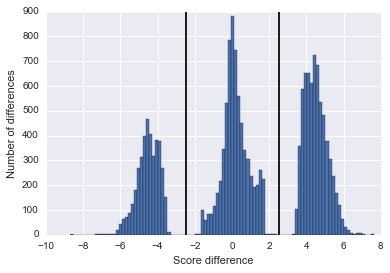

In [38]:
pd.Series(motif_d.values.flatten()).dropna().hist(bins=100)
ymin, ymax = plt.ylim()
plt.vlines(-2.5, ymin, ymax)
plt.vlines(2.5, ymin, ymax)
plt.ylabel('Number of differences')
plt.xlabel('Score difference');

It seems that a score difference greater than 2.5 in magnitude probably
represents a pretty big effect. I'll say these are disruptions.

In [39]:
motif_disrupt = motif_d.abs() >= 2.5
motif_disrupt = motif_disrupt[motif_disrupt.sum(axis=1) > 0]
motif_disrupt.to_csv(os.path.join(outdir, 'motif_disruption.tsv'), sep='\t')
#motif_disrupt.columns = ['{}_motif_disrupted'.format(x) for x in motif_disrupt.columns]
#gene_variants = gene_variants.merge(motif_disrupt, left_on='location', right_index=True, how='left')

In [40]:
print('{:,} variants disrupt a motif.'.format(motif_disrupt.shape[0]))

3,225 variants disrupt a motif.


In [41]:
# I'll convert the peak_overlaps into TF overlaps.
tdf = motif_disrupt.copy(deep=True)
tdf.columns = [motif_info_full.ix[x, 'target'] for x in tdf.columns]
d = {}
for c in tdf.columns:
    t = tdf[c]
    if len(t.shape) == 2:
        d[c] = t[c].sum(axis=1) > 0
    else:
        d[c] = t
tf_disrupt = pd.DataFrame(d)
tf_disrupt.to_csv(os.path.join(outdir, 'tf_disruption.tsv'), sep='\t')

In [42]:
t = pd.DataFrame([tf_disrupt.index], index=['location']).T
t['tf_disrupt'] = True
gene_variants = gene_variants.merge(t, how='outer')
gene_variants.ix[gene_variants['tf_disrupt'].isnull(), 'tf_disrupt'] = False

In [43]:
t = pd.DataFrame([tf_overlap[tf_overlap.sum(axis=1) > 0].index], index=['location']).T
t['tf_overlap'] = True
gene_variants = gene_variants.merge(t, how='outer')
gene_variants.ix[gene_variants['tf_overlap'].isnull(), 'tf_overlap'] = False

In [44]:
tdf = gene_variants[['location', 'ref', 'alt']]# + tf_cols]
tdf = tdf.drop_duplicates()
tdf.index = tdf.location
tdf = tdf.drop('location', axis=1)
tf_overlap_yes = tf_overlap[tf_overlap.sum(axis=1) > 0]
tdf = tdf.ix[tf_overlap_yes.index]

d = {}
for i in tf_overlap_yes.index:
    d[i] = list(tf_overlap_yes.ix[i][tf_overlap_yes.ix[i]].index)
se = pd.Series(d)
se = se[tdf.index]
target_to_motif = pd.Series(motif_info.index, index=motif_info.target)
tdf['motifs'] = se.apply(lambda x: list(target_to_motif[x]))

In [45]:
motif_disrupt_info = tdf.copy(deep=True)
motif_disrupt_info['disrupt'] = False
motif_disrupt_info.ix[motif_disrupt.index, 'disrupt'] = True
motif_disrupt_info['overlap_disrupt'] = False
motif_disrupt_info['not_overlap_disrupt'] = False
t = motif_disrupt_info[motif_disrupt_info.disrupt == True]

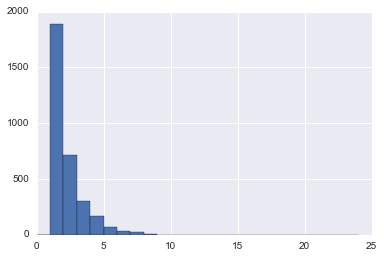

In [46]:
tf_disrupt.sum(axis=1).hist(bins=range(0, 25))

## CNV eQTLS

I'll mark which genes have an overlapping significant CNV.

In [47]:
t = pd.DataFrame(index=list(set(cnv_gv[cnv_gv.cnv_overlaps_gene].gene_id)))
t['cnv_eqtl'] = True
gene_variants = gene_variants.merge(t, how='outer', left_on='gene_id', right_index=True)
gene_variants.ix[gene_variants.cnv_eqtl.isnull(), 'cnv_eqtl'] = False

In [48]:
fn = os.path.join(outdir, 'gene_variants_annotated.pickle')
gene_variants.to_pickle(fn)

## Feature Exploration

In [49]:
n = gene_variants.shape[0]
print('{:,} total SNV and indel associations.'.format(n))
n = len(set(gene_variants.location))
print('{:,} total distinct SNV and indels with significant associations.'.format(n))

255,393 total SNV and indel associations.
197,674 total distinct SNV and indels with significant associations.


In [50]:
n = len(set(gene_variants[gene_variants.nmd == True].gene_id))
print('{:,} genes with a significant NMD variant.'.format(n))
n = len(set(gene_variants[gene_variants.cnv_eqtl == True].gene_id))
print('{:,} genes with a significant overlapping CNV.'.format(n))
n = len(set(gene_variants[gene_variants.cnv_eqtl == True].gene_id) |
        set(gene_variants[gene_variants.nmd == True].gene_id))
print('{:,} total in these groups.'.format(n))

10 genes with a significant NMD variant.
88 genes with a significant overlapping CNV.
98 total in these groups.


In [51]:
gene_variants.variant_type.value_counts()

snv    227569
del     15294
ins     12508
Name: variant_type, dtype: int64

In [52]:
n = (gene_variants.gene_id.value_counts() > 1).value_counts()[False]
print('{:,} of {:,} genes have only one significant variant.'.format(n, len(set(gene_variants.gene_id))))

2,197 of 5,704 genes have only one significant variant.


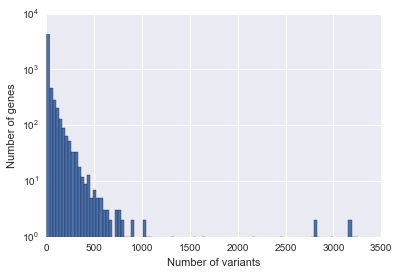

In [53]:
gene_variants.gene_id.value_counts().hist(bins=100, log=True)
plt.ylabel('Number of genes')
plt.xlabel('Number of variants');

In [54]:
gene_gb = gene_variants.groupby('gene_id')
num_genes = len(set(gene_variants.gene_id))

In [55]:
n = (gene_gb.exonic.sum() > 0).value_counts()[True]
print('{:,} of {:,} genes have at least one significant exonic variant.'.format(
    n, num_genes))
m = (gene_gb.exonic_same_gene.sum() > 0).value_counts()[True]
print('{:,} of these {:,} genes have at least one significant variant in their own exon.'.format(
    m, n))

2,701 of 5,704 genes have at least one significant exonic variant.
2,016 of these 2,701 genes have at least one significant variant in their own exon.


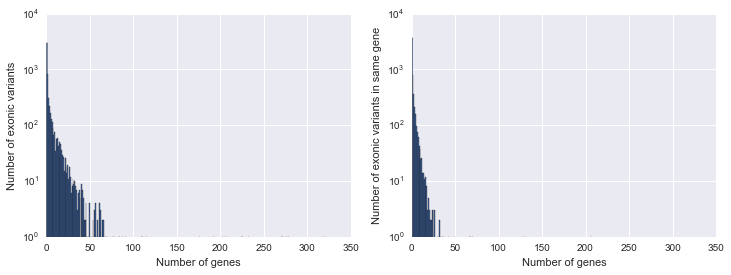

In [56]:
fig, axs = plt.subplots(1, 2, figsize=[12, 4])
ax = gene_gb.exonic.sum().hist(log=True, bins=range(0, int(gene_gb.exonic.sum().max())), ax=axs[0])
ax.set_ylabel('Number of exonic variants')
ax.set_xlabel('Number of genes')
ax = gene_gb.exonic_same_gene.sum().hist(log=True, bins=range(0, int(gene_gb.exonic.sum().max())), ax=axs[1])
ax.set_ylabel('Number of exonic variants in same gene')
ax.set_xlabel('Number of genes');

In [57]:
n = (gene_gb.utr.sum() > 0).value_counts()[True]
print('{:,} of {:,} genes have at least one significant UTR variant.'.format(
    n, len(set(gene_variants.gene_id))))
m = (gene_gb.utr_same_gene.sum() > 0).value_counts()[True]
print('{:,} of these {:,} genes have at least one significant variant in their own UTR.'.format(
    m, n))

2,036 of 5,704 genes have at least one significant UTR variant.
1,319 of these 2,036 genes have at least one significant variant in their own UTR.


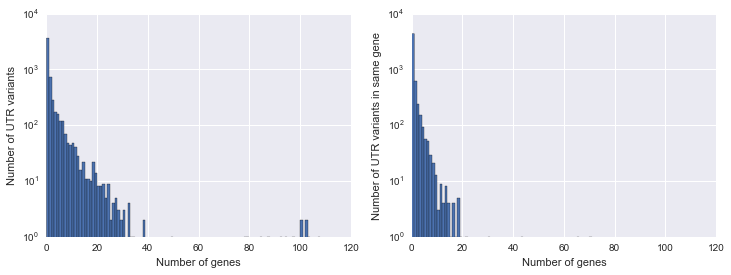

In [58]:
fig, axs = plt.subplots(1, 2, figsize=[12, 4])
ax = gene_gb.utr.sum().hist(log=True, bins=range(0, int(gene_gb.utr.sum().max())), ax=axs[0])
ax.set_ylabel('Number of UTR variants')
ax.set_xlabel('Number of genes')
ax = gene_gb.utr_same_gene.sum().hist(log=True, bins=range(0, int(gene_gb.utr.sum().max())), ax=axs[1])
ax.set_ylabel('Number of UTR variants in same gene')
ax.set_xlabel('Number of genes');

In [59]:
for c in [x for x in gene_variants.columns if 'dnase' in x]:
    vc = gene_variants[c].value_counts()
    print('{}\t{:.2f}%'.format(c, float(vc[True]) / vc.sum()))

iPS_DF_6.9_roadmap_dnase	0.05%
iPS_DF_19.11_roadmap_dnase	0.05%
H1_roadmap_dnase	0.04%
H9_roadmap_dnase	0.05%
iPSC_ENCSR000EKK_dnase	0.04%
iPSC_ENCSR000EKJ_dnase	0.04%
iPSC_ENCSR000EKI_dnase	0.05%
iPSC_ENCSR000EKH_dnase	0.02%
H7-hESC_ENCSR000EMZ_dnase	0.02%
H1-hESC_ENCSR000EMU_dnase	0.02%
H9_ENCSR000EJP_dnase	0.02%
H7-hESC_ENCSR000EJO_dnase	0.07%
H1-hESC_ENCSR000EJN_dnase	0.06%


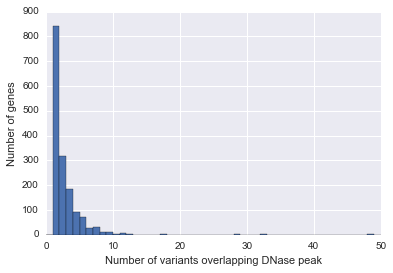

In [60]:
vc = gene_variants.ix[gene_variants['H1-hESC_ENCSR000EMU_dnase'] == True, 'gene_id'].value_counts()
vc.hist(bins=range(0, vc.max() + 1))
plt.ylabel('Number of genes')
plt.xlabel('Number of variants overlapping DNase peak');

In [61]:
gene_variants['significance.level_maurano'].value_counts()

not_imbalanced           12177
imbalanced_(5%_FDR)       2589
imbalanced_(0.1%_FDR)      290
Name: significance.level_maurano, dtype: int64

In [62]:
maurano_res['significance.level_maurano'].value_counts()

not_imbalanced           297687
imbalanced_(5%_FDR)       55141
imbalanced_(0.1%_FDR)      9456
Name: significance.level_maurano, dtype: int64

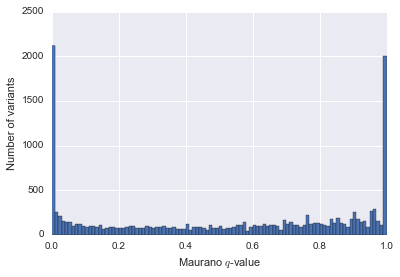

In [63]:
gene_variants['q.value_maurano'].hist(bins=100)
plt.ylabel('Number of variants')
plt.xlabel('Maurano $q$-value');

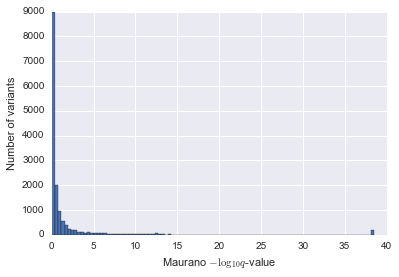

In [64]:
se = gene_variants['q.value_maurano'].dropna()
se += se[se > 0].min()
(-np.log10(se)).hist(bins=100)
plt.ylabel('Number of variants')
plt.xlabel('Maurano $-\log_{10}q$-value');

### Single variant genes

I'm going to look at genes for which there is only one significant
variant. In theory, these should often be the causal variants.

In [65]:
se = gene_variants.gene_id.value_counts() == 1
genes = set(se[se].index)
tdf = gene_variants[gene_variants.gene_id.apply(lambda x: x in genes)]

In [66]:
n = tdf.exonic.value_counts()[True]
print('{} of {} genes have an exonic variant.'.format(n, tdf.shape[0]))
n = tdf.utr.value_counts()[True]
print('{} of {} genes have a UTR variant.'.format(n, tdf.shape[0]))
n = tdf['H1-hESC_ENCSR000EMU_dnase'].value_counts()[True]
print('{} of {} genes have a variant in H1-hESC_ENCSR000EMU DNase peaks.'.format(n, tdf.shape[0]))

313 of 2197 genes have an exonic variant.
163 of 2197 genes have a UTR variant.
114 of 2197 genes have a variant in H1-hESC_ENCSR000EMU DNase peaks.


In [67]:
maurano_res['significance.level_maurano'].value_counts() / maurano_res.shape[0]

not_imbalanced           0.821695
imbalanced_(5%_FDR)      0.152204
imbalanced_(0.1%_FDR)    0.026101
Name: significance.level_maurano, dtype: float64

In [68]:
(gene_variants['significance.level_maurano'].value_counts() / 
 gene_variants['significance.level_maurano'].value_counts().sum())

not_imbalanced           0.808781
imbalanced_(5%_FDR)      0.171958
imbalanced_(0.1%_FDR)    0.019261
Name: significance.level_maurano, dtype: float64

In [69]:
tdf['significance.level_maurano'].value_counts() / tdf['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.748954
imbalanced_(5%_FDR)      0.230126
imbalanced_(0.1%_FDR)    0.020921
Name: significance.level_maurano, dtype: float64

In [70]:
tdf['significance.level_maurano'].value_counts()

not_imbalanced           179
imbalanced_(5%_FDR)       55
imbalanced_(0.1%_FDR)      5
Name: significance.level_maurano, dtype: int64

In [71]:
t = gene_variants.sort_values(by=['gene_id', 'pvalue'])
t = t.drop_duplicates(subset='gene_id')

In [72]:
t['significance.level_maurano'].value_counts() / t['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.718702
imbalanced_(5%_FDR)      0.258114
imbalanced_(0.1%_FDR)    0.023184
Name: significance.level_maurano, dtype: float64

In [73]:
n = len(set(tf_disrupt.index) & set(tdf.location))
print('The eQTL variant for {} genes disrupts a TF.'.format(n))
n = len(set(tf_disrupt.index) & set(tdf.location) & 
        set(tdf.ix[tdf['q.value_maurano'] < 0.05, 'location']))
print('{} of these are significant in Maurano et al.'.format(n))

The eQTL variant for 105 genes disrupts a TF.
19 of these are significant in Maurano et al.


## Fine Mapping

I'll start by removing genes are predicted to undergo NMD. I may also want to remove
genes where a CNV overlaps the gene.

In [74]:
n = qvalues.perm_sig.sum() - len(set(gene_variants.gene_id))
print('{} genes only had CNV associations.'.format(n))

42 genes only had CNV associations.


In [75]:
gene_variants_f = gene_variants[(gene_variants.gene_has_nmd_variant == False)]
a = len(set(gene_variants_f.gene_id))
b = len(set(gene_variants.gene_id))
print('{:,} of {:,} genes don\'t have a significant NMD variant.'.format(a, b))
print('{:,} genes have a significant NMD variant.'.format(b - a))

5,672 of 5,704 genes don't have a significant NMD variant.
32 genes have a significant NMD variant.


In [76]:
a = len(set(gene_variants_f.gene_id))
gene_variants_f = gene_variants_f[gene_variants_f.cnv_eqtl == False]
b = len(set(gene_variants_f.gene_id))
print('{:,} of {:,} genes don\'t have a significant overlapping CNV'.format(b, a))
print('{:,} genes have a significant overlapping CNV'.format(a - b))

5,606 of 5,672 genes don't have a significant overlapping CNV
66 genes have a significant overlapping CNV


In [77]:
n = qvalues.perm_sig.sum() - len(set(gene_variants_f.gene_id))
print('Removed {} genes due to CNV or NMD eQTLs.'.format(n))
print('{:,} remaining variants.'.format(len(set(gene_variants_f.location))))
print('{:,} remaining genes.'.format(len(set(gene_variants_f.gene_id))))

Removed 140 genes due to CNV or NMD eQTLs.
191,871 remaining variants.
5,606 remaining genes.


In [78]:
no_cnv_nmd_vars = gene_variants_f.location.drop_duplicates()
gene_variants_f.to_csv(os.path.join(outdir, 'no_cnv_nmd_vars_gv.tsv'), sep='\t')

In [79]:
a = peak_overlap.shape[1]
b = tf_overlap.shape[1]
print('Overlapped variants with {} ENCODE experiments for {} TFs.'.format(a, b))

Overlapped variants with 40 ENCODE experiments for 34 TFs.


In [80]:
n = sum(peak_overlap.ix[gene_variants_f.location.drop_duplicates()].sum(axis=1) > 0)
print(('{:,} of {:,} variants for {:,} eGenes overlapped at least one peak'.format(
            n, gene_variants_f.location.drop_duplicates().shape[0], 
            len(set(gene_variants_f[gene_variants_f.tf_overlap].gene_id)))))

7,840 of 191,871 variants for 2,244 eGenes overlapped at least one peak


In [81]:
n = sum(tf_disrupt.ix[gene_variants_f.location.drop_duplicates()].sum(axis=1) > 0)
print('{:,} of {:,} variants disrupted at least one TF.'.format(
        n, gene_variants_f.location.drop_duplicates().shape[0]))

3,140 of 191,871 variants disrupted at least one TF.


In [82]:
gene_variants_f = gene_variants_f[gene_variants_f.tf_disrupt]

In [83]:
len(set(gene_variants_f.gene_id))

1526

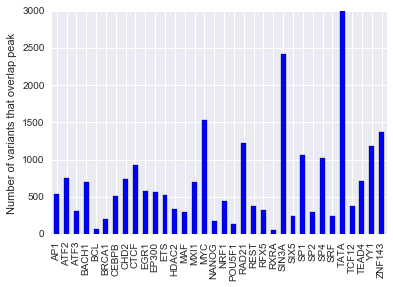

In [84]:
tf_overlap.sum().plot.bar()
plt.ylabel('Number of variants that overlap peak');

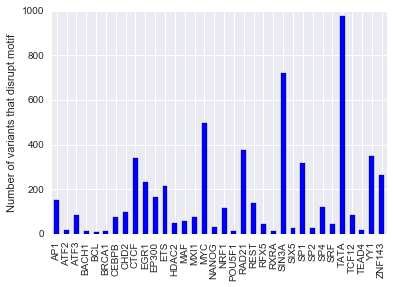

In [85]:
tf_disrupt.sum().plot.bar()
plt.ylabel('Number of variants that disrupt motif');

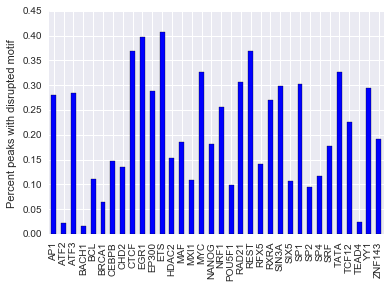

In [86]:
(tf_disrupt.sum() / tf_overlap.sum()).plot.bar()
plt.ylabel('Percent peaks with disrupted motif');

In [88]:
tf_disrupt['NANOG'].sum()

32

In [89]:
gene_variants_f['significance.level_maurano'].value_counts() / gene_variants_f['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.612960
imbalanced_(5%_FDR)      0.371278
imbalanced_(0.1%_FDR)    0.015762
Name: significance.level_maurano, dtype: float64

In [90]:
gene_variants['significance.level_maurano'].value_counts() / gene_variants['significance.level_maurano'].value_counts().sum()

not_imbalanced           0.808781
imbalanced_(5%_FDR)      0.171958
imbalanced_(0.1%_FDR)    0.019261
Name: significance.level_maurano, dtype: float64

In [91]:
a = set(gene_variants_f.location) & set(maurano_res.index)
b = set(no_cnv_nmd_vars) & set(maurano_res.index)

print('Maurano assayed {:,} of the eQTL variants.'.format(len(a) + len(b)))
print ('{:.2f}% of all variants tested in Maurano paper were significant (q < 0.05).'.format(
    sum(maurano_res['q.value_maurano'] < 0.05) / float(maurano_res.shape[0]) * 100))
print('{:,} of {:,} ({:.2f}%) putative eQTNs were significant in Maurano (q < 0.05).'.format(
        sum(maurano_res.ix[a, 'q.value_maurano'] < 0.05), len(a),
        sum(maurano_res.ix[a, 'q.value_maurano'] < 0.05) / float(len(a)) * 100))
print('{:,} of {:,} ({:.2f}%) sig. variants that were not putative eQTNs were significant in Maurano (q < 0.05).'.format(
        sum(maurano_res.ix[b, 'q.value_maurano'] < 0.05), len(b),
        sum(maurano_res.ix[b, 'q.value_maurano'] < 0.05) / float(len(b)) * 100))

Maurano assayed 13,664 of the eQTL variants.
17.83% of all variants tested in Maurano paper were significant (q < 0.05).
373 of 992 (37.60%) putative eQTNs were significant in Maurano (q < 0.05).
2,430 of 12,672 (19.18%) sig. variants that were not putative eQTNs were significant in Maurano (q < 0.05).


In [92]:
pe_sig = sum(maurano_res.ix[a, 'q.value_maurano'] < 0.05)
pe_not_sig = len(a) - pe_sig
not_pe_sig = sum(maurano_res['q.value_maurano'] < 0.05)
not_pe_not_sig = maurano_res.shape[0] - not_pe_sig
odds, p = stats.fisher_exact([[pe_sig, pe_not_sig], [not_pe_sig, not_pe_not_sig]])
print('peQTNs enriched for altering TF binding relative to all Maurano variants '
      '(odds={:.4f}, p={:.4e}, Fisher).'.format(odds, p))

pe_sig = sum(maurano_res.ix[a, 'q.value_maurano'] < 0.05)
pe_not_sig = len(a) - pe_sig
not_pe_sig = sum(maurano_res.ix[b, 'q.value_maurano'] < 0.05)
not_pe_not_sig = len(b) - not_pe_sig
odds, p = stats.fisher_exact([[pe_sig, pe_not_sig], [not_pe_sig, not_pe_not_sig]])
print('peQTNs enriched for altering TF binding relative to non-peQTN eQTL variants '
      '(odds={:.4f}, p={:.4e}, Fisher).'.format(odds, p))

peQTNs enriched for altering TF binding relative to all Maurano variants (odds=2.7776, p=1.2216e-48, Fisher).
peQTNs enriched for altering TF binding relative to non-peQTN eQTL variants (odds=2.5398, p=4.4460e-38, Fisher).


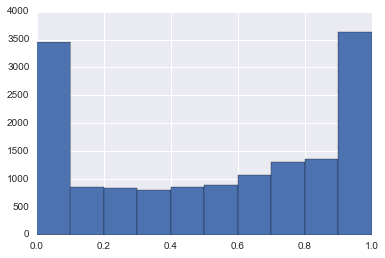

In [93]:
gene_variants['q.value_maurano'].hist()

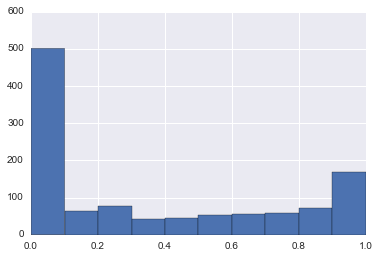

In [94]:
gene_variants_f['q.value_maurano'].hist()

In [95]:
n = len(set(gene_variants_f.gene_id))
a = sum(gene_variants_f.gene_id.value_counts() == 1)
print('{:,} of {:,} ({:.2f}%) eGenes have one putative eQTN.'.format(a, n, a / float(n) * 100))
a = sum(gene_variants_f.gene_id.value_counts() <= 5)
print('{:,} of {:,} ({:.2f}%) eGenes have five or less putative eQTNs.'.format(a, n, a / float(n) * 100))

766 of 1,526 (50.20%) eGenes have one putative eQTN.
1,404 of 1,526 (92.01%) eGenes have five or less putative eQTNs.


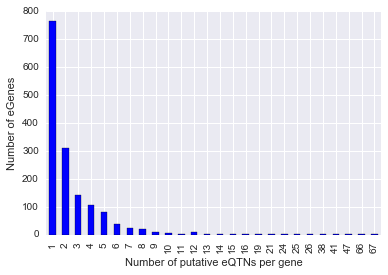

In [96]:
vc = gene_variants_f.gene_id.value_counts().value_counts().sort_index()
vc.plot(kind='bar')
plt.ylabel('Number of eGenes')
plt.xlabel('Number of putative eQTNs per gene');

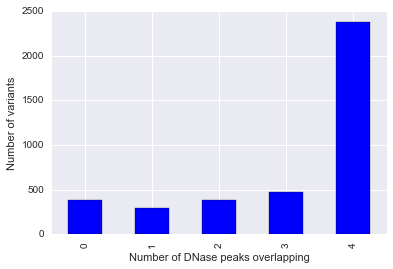

In [97]:
gene_variants_f['roadmap_dnase_num'] = \
    gene_variants_f[[x for x in gene_variants_f.columns 
                    if '_roadmap_dnase' in x]].sum(axis=1)

se = gene_variants_f.roadmap_dnase_num.value_counts()
se = se[range(se.shape[0])]
se.plot(kind='bar')
plt.ylabel('Number of variants')
plt.xlabel('Number of DNase peaks overlapping');

In [98]:
a = gene_variants_f[gene_variants_f.roadmap_dnase_num > 0].drop_duplicates(subset='location').shape[0]
b = gene_variants_f.drop_duplicates(subset='location').shape[0]
print('{:,} of {:,} ({:.2f}%) putative eQTNs overlap a DHS.'.format(a, b, a / float(b) * 100))
a = gene_variants_f[gene_variants_f.roadmap_dnase_num == 4].drop_duplicates(subset='location').shape[0]
b = gene_variants_f.drop_duplicates(subset='location').shape[0]
print('{:,} of {:,} ({:.2f}%) putative eQTNs overlap DHS present in all four lines.'.format(a, b, a / float(b) * 100))

2,835 of 3,140 (90.29%) putative eQTNs overlap a DHS.
1,923 of 3,140 (61.24%) putative eQTNs overlap DHS present in all four lines.


[Wen et al. 2015](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1005176) says 50% of cis-eQTLs are concentrated within 20kb of the TSS.

In [99]:
n = sum(gene_variants_f.tss_dist_abs < 20000)
p = float(n) / gene_variants_f.shape[0]
print('{:,} of {:,} ({:.1f}%) putative causal variants are within 20kb of the nearest TSS.'.format(
        n, gene_variants_f.shape[0], p * 100))

2,106 of 3,905 (53.9%) putative causal variants are within 20kb of the nearest TSS.


In [100]:
lead_variants_single_f.head()

,chrom,start,end,marker_id,ns,ac,callrate,genocnt,maf,stat,...,gene_type,AF,EUR_AF,SAS_AF,AFR_AF,AMR_AF,EAS_AF,perm_pvalue,perm_qvalue,perm_sig
chr1:169862063-169862064:ENSG00000000460.12,chr1,169862063,169862064,1:169862064_C/G_rs12131357,215,35,1,182/31/2,0.08140,5.4640,...,protein_coding,0.084066,0.1044,0.0716,0.1505,0.0548,0.0089,0.000100,0.000253,True
chr6:46112388-46112389:ENSG00000001561.6,chr6,46112388,46112389,6:46112389_A/G_rs1048077,215,290,1,27/86/102,0.32558,8.3460,...,protein_coding,0.821885,0.6809,0.7935,0.9607,0.7954,0.8264,0.000100,0.000253,True
chr12:1056029-1056030:ENSG00000002016.12,chr12,1056029,1056030,12:1056030_C/G_rs12822733,215,63,1,157/53/5,0.14651,-5.8603,...,protein_coding,0.172324,0.1879,0.2311,0.1732,0.1182,0.1359,0.000100,0.000253,True
chr12:9095748-9095749:ENSG00000003056.3,chr12,9095748,9095749,12:9095749_T/C_rs7309922,215,199,1,69/93/53,0.46279,-8.2255,...,protein_coding,0.358027,0.4473,0.4796,0.1536,0.3905,0.3968,0.000100,0.000253,True
chr7:9247738-9247739:ENSG00000003147.13,chr7,9247738,9247739,7:9247739_A/G_rs12537168,215,129,1,104/93/18,0.30000,-4.6270,...,protein_coding,0.188299,0.3032,0.2464,0.0189,0.1816,0.2440,0.011628,0.017456,True


In [101]:
n = len(set(gene_variants_f.location + ':' + gene_variants_f.gene_id) & set(lead_variants_single_f.index))
print('{:,} of my {:,} putative causal variants ({:.2f}%)  are also the most significant variants'.format(
        n, gene_variants_f.shape[0], float(n) / gene_variants_f.shape[0] * 100))
a = len(set(gene_variants_f.gene_id))
print('The lead variant is a peQTN for {:,} of {:,} ({:.2f}%) genes with peQTNs.'.format(n, a, n / float(a) * 100))

298 of my 3,905 putative causal variants (7.63%)  are also the most significant variants
The lead variant is a peQTN for 298 of 1,526 (19.53%) genes with peQTNs.


In [102]:
gene_variants_f.index = gene_variants_f.location + ':' + gene_variants_f.gene_id

In [103]:
gene_variants_f.to_csv(os.path.join(outdir, 'peqtns.tsv'), sep='\t')

In [104]:
snpsnap = None

def get_independent_snvs(df):
    ld_beds = glob.glob('/publicdata/1KGP_20151103/LD_20151110/tabix/*EUR*.bed.gz')
    ld_beds = dict(zip([os.path.split(x)[1].split('_')[0] for x in ld_beds], ld_beds))
    df = df.drop_duplicates(subset=['location'])
    tdf = df[['chrom', 'start', 'end', 'pvalue']]
    tdf['start'] = tdf.end.astype(int)
    tdf['end'] = tdf.end.astype(int)
    tdf.index = tdf.chrom + ':' + tdf.end.astype(int).astype(str)
    indep = cpb.analysis.ld_prune(tdf, ld_beds, snvs=list(snpsnap.index)).drop('pvalue', axis=1)
    return indep

def get_snpsnap():
    snpsnap_fns = glob.glob('/publicdata/SNPsnap_20151104/EUR_parse/*.tab')
    dfs = []
    for tab in snpsnap_fns:
        df = pd.read_table(tab, index_col=0, low_memory=False)
        tdf = df[['snp_maf', 'dist_nearest_gene_snpsnap_protein_coding',
                  'friends_ld08']]
        tdf.index = 'chr' + tdf.index
        dfs.append(tdf)
    snps = pd.concat(dfs)
    snps['maf_bin'] = pd.cut(snps.snp_maf, np.arange(0, 0.55, 0.05))
    snps['ld_bin'] = pd.cut(np.log10(snps.friends_ld08.replace(np.nan, 0) + 1), 10)
    snps['dist_bin'] = pd.cut(np.log10(snps.dist_nearest_gene_snpsnap_protein_coding
                                       + 1), 10)
    snps = snps[['maf_bin', 'ld_bin', 'dist_bin']]
    return snps

fn = os.path.join(outdir, 'independent_fine_mapped_variants.bed')
if not os.path.exists(fn):
    if snpsnap is None:
        snpsnap = get_snpsnap()
    indep = get_independent_snvs(gene_variants_f)
    indep.to_csv(os.path.join(outdir, 'independent_fine_mapped_variants.tsv'), sep='\t')
    s = '\n'.join(indep[['chrom', 'start', 'end']].apply(
            lambda x: '\t'.join([str(y) for y in x.values]), axis=1)) + '\n'
    bt = pbt.BedTool(s, from_string=True)
    bt = bt.sort()
    bt.saveas(fn)

In [105]:
fn = os.path.join(outdir, 'independent_fine_mapped_variants_no_hla.bed')
if not os.path.exists(fn):
    if snpsnap is None:
        snpsnap = get_snpsnap()
    indep = get_independent_snvs(gene_variants_f[gene_variants_f.gene_name.apply(lambda x: 'HLA' not in x)])
    indep.to_csv(os.path.join(outdir, 'independent_fine_mapped_variants_no_hla.tsv'), sep='\t')
    s = '\n'.join(indep[['chrom', 'start', 'end']].apply(
            lambda x: '\t'.join([str(y) for y in x.values]), axis=1)) + '\n'
    bt = pbt.BedTool(s, from_string=True)
    bt = bt.sort()
    bt.saveas(fn)

### Random motif disruption

I want to look into how many motif disruptions I would get by chance when searching
this many motifs against this number of variants. There may be a few ways to do this,
though it is tricky. One idea is to randomly assign motifs instead of search the motifs
for the ChIP-seq peak that is overlapped. For instance, if a variant overlaps a JUN peak,
choose motifs for a random different TF. The problem here is that the motifs are correlated
(e.g. a different TF could still be enriched for a JUN motif) so sometimes you may
still expect a disruption. This motif similarity (which I explore some at the end of this
notebook) creates a lot of issues like this.

Another idea is to just look for motif disruptions among the variants that did not overlap
TF peaks. I used 191,871 variants for the fine mapping. These were intersected
with ChIP-seq peaks and 7,840 overlapped a peak for at least one TF. Note that these numbers
are less than reported above (where I actually did the overlapping) because for the fine mapping
I removed variants whose eGene overlapped a CNV eQTL or that had an eQTL variant predicted to 
cause NMD. I looked for motif disruptions for these 7,840 and found 3,225
disruptions. So I want to take the 191,871 - 7,840 and randomly choose sets of 7,840. Then
I'll randomly assign the same motifs I used for the real 7,840 and see how many motif disruptions
I get by chance. This will be a slightly biased estimate because some of the variants that did
not overlap peaks probably overlap a peak that was not assayed and may disrupt a motif that I'm 
searching give the motif similarity. I think I should still see a difference between the real and
randomly chosen variants though.

In [116]:
fn = os.path.join(outdir, 'num_disrupt_random.tsv')
if not os.path.exists(fn):
    random.seed('20160725')
    tdf = gene_variants[['location', 'ref', 'alt']]# + tf_cols]
    tdf = tdf.drop_duplicates()
    tdf.index = tdf.location
    tdf = tdf.drop('location', axis=1)
    tdf = tdf.ix[no_cnv_nmd_vars.values]
    tf_overlap_yes = tf_overlap[tf_overlap.sum(axis=1) > 0]

    d = {}
    for i in tf_overlap_yes.index:
        d[i] = list(tf_overlap_yes.ix[i][tf_overlap_yes.ix[i]].index)
    se = pd.Series(d)
    se = se[se.index & tdf.index]
    target_to_motif = pd.Series(motif_info.index, index=motif_info.target)
    
    from ipyparallel import Client
    parallel_client = Client(profile='parallel')
    dview = parallel_client[:]
    print('Cluster has {} engines.'.format(len(parallel_client.ids)))
    
    with dview.sync_imports():
        import cdpybio
        import cardipspy
        
    %px cpb = cdpybio
    %px cpy = cardipspy
    
    #dview.push(dict(tdf=tdf));
    dview.push(dict(matrices=matrices));

    random_mds = []
    for i in range(30):
        i = random.sample(tdf.index, (peak_overlap.ix[no_cnv_nmd_vars.values].sum(axis=1) > 0).sum())
        tdf_r = tdf.ix[i]
        tdf_r['motifs'] = se.apply(lambda x: list(target_to_motif[x])).values

        dview.push(dict(tdf_r=tdf_r));

        res = dview.map_sync(lambda i: cpb.moodsext.find_motif_disruptions(
                i, tdf_r.ix[i, 'ref'], tdf_r.ix[i, 'alt'], cpy.hg19, 
                {k:matrices[k] for k in tdf_r.ix[i, 'motifs']}), tdf_r.index)

        a = []
        b = []
        for i,p in enumerate(tdf_r.index):
            if res[i].shape[0] > 0:
                a.append(p)
                b.append(res[i])
        d = dict(zip(a,b))
        p = pd.Panel(d)
        motif_d_r = p.ix[:, :, 'score_diff'].T

        motif_disrupt_r = motif_d_r.abs() >= 2.5
        motif_disrupt_r = motif_disrupt_r[motif_disrupt_r.sum(axis=1) > 0]
        random_mds.append(motif_disrupt_r)

    num_disrupt_random = pd.Series([x.shape[0] for x in random_mds])
    num_disrupt_random.to_csv(fn, sep='\t')
else:
    num_disrupt_random = pd.read_table(fn, index_col=0, squeeze=True, header=None)
    
print('There were {} variants that disrupted motifs on average (s.d. {}, {} samples).'.format(
    num_disrupt_random.mean(), num_disrupt_random.std(), num_disrupt_random.shape[0]))

There were 2433.7 variants that disrupted motifs on average (s.d. 41.7365712453, 30 samples).


### $p$-value comparison

In [117]:
leads_p = lead_variants_single_f[lead_variants_single_f.gene_id.apply(lambda x: x in set(gene_variants_f.gene_id))]

In [118]:
gvf_p = gene_variants_f.sort_values(by='pvalue').drop_duplicates(subset='gene_id')

In [119]:
leads_p.sort_values(by='gene_id', inplace=True)
gvf_p.sort_values(by='gene_id', inplace=True)

In [120]:
pvals = pd.DataFrame({'qtn':gvf_p.pvalue.values, 'lead':leads_p.pvalue.values},
                    index=gvf_p.gene_id)
pvals_log = -np.log10(pvals)

pvals_log['secondary'] = False
pvals_log.ix[set(secondary_qvalues[secondary_qvalues.perm_sig].index) & set(pvals_log.index),
            'secondary'] = True

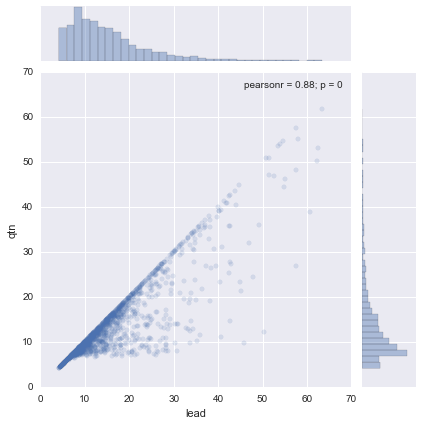

In [121]:
sns.jointplot(pvals_log.lead, pvals_log.qtn, kind='scatter', alpha=0.15);

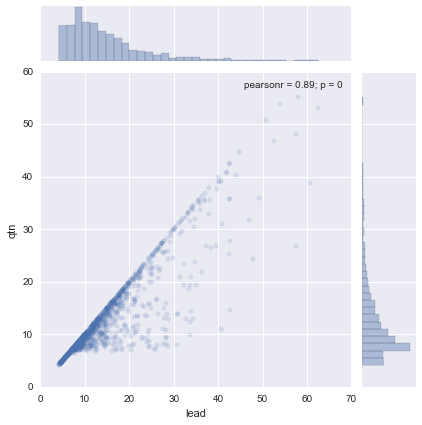

In [122]:
sns.jointplot(pvals_log[pvals_log.secondary == False].lead, 
              pvals_log[pvals_log.secondary == False].qtn, kind='scatter', alpha=0.15);

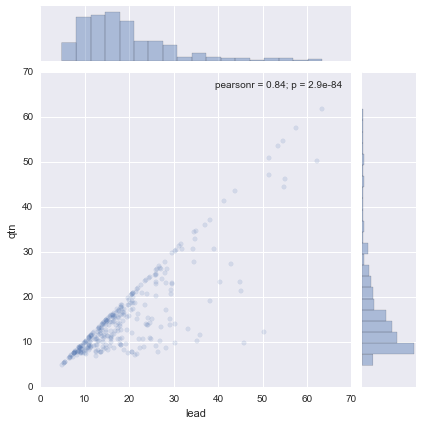

In [123]:
sns.jointplot(pvals_log[pvals_log.secondary].lead, 
              pvals_log[pvals_log.secondary].qtn, kind='scatter', alpha=0.15);

In [124]:
pvals_log['pdiff'] = pvals_log.lead - pvals_log.qtn

In [125]:
diff_sec = pvals_log[pvals_log.secondary & (pvals_log.pdiff > 1)].shape[0]
no_diff_sec = pvals_log[pvals_log.secondary & (pvals_log.pdiff <= 1)].shape[0]
diff_no_sec = pvals_log[(pvals_log.secondary == False) & (pvals_log.pdiff > 1)].shape[0]
no_diff_no_sec = pvals_log[(pvals_log.secondary == False) & (pvals_log.pdiff <= 1)].shape[0]
s,p = stats.fisher_exact([[diff_sec, no_diff_sec], [diff_no_sec, no_diff_no_sec]])
print('eGenes with secondary eQTLs are enriched for having their peQTN differ in significance '
      'from the lead (p={:.2e})'.format(p))

eGenes with secondary eQTLs are enriched for having their peQTN differ in significance from the lead (p=4.48e-13)


In [126]:
a = sum(pvals_log.pdiff < 1)
b = pvals_log.shape[0]
print('For {:,} of {:,} ({:.2f}%) genes with peQTNs, the peQTN p-value is within one '
      'order of magnitude of the lead.'.format(a, b, a / float(b) * 100))

For 928 of 1,526 (60.81%) genes with peQTNs, the peQTN p-value is within one order of magnitude of the lead.


In [127]:
a = sum(pvals_log.pdiff < 2)
b = pvals_log.shape[0]
print('For {:,} of {:,} ({:.2f}%) genes with peQTNs, the peQTN p-value is within two '
      'orders of magnitude of the lead.'.format(a, b, a / float(b) * 100))

For 1,107 of 1,526 (72.54%) genes with peQTNs, the peQTN p-value is within two orders of magnitude of the lead.


### Validation


#### Proof of concept

I'd like to find some examples to validate as a proof of concept. Some things to consider are:

* known or novel motif
* which TF (relevant to stem cells?)
* association $p$-value
* overlap DHS?

In [128]:
tdf = gene_variants_f.copy(deep=True)
# Disrupt known motif
t = motif_disrupt.ix[set(tdf.location)]
t = t[[x for x in t.columns if 'known' in x]]
t = t.sum(axis=1)
t = t[t > 0]
tdf = tdf[tdf.location.apply(lambda x: x in set(t.index))]
print(tdf.shape[0])
# Within one order of magnitude of the lead
tdf = tdf.merge(pvals_log, left_on='gene_id', right_index=True)
tdf = tdf[tdf.pdiff < 1]
print(tdf.shape[0])
# DHS present in at least 11 lines
tdf['dhs_count'] = tdf[[x for x in tdf.columns if 'dnase' in x]].sum(axis=1)
tdf = tdf[tdf.dhs_count >= 11]
print(tdf.shape[0])
# Only SNVs
tdf = tdf[tdf.ref.apply(lambda x: len(x)) == 1]
tdf = tdf[tdf.alt.apply(lambda x: len(x)) == 1]
print(tdf.shape[0])
# Significant in Maurano
tdf = tdf[tdf.location.apply(lambda x: x in set(tdf.location) & 
                             set(maurano_res[maurano_res['q.value_maurano'] < 0.05].index))]
print(tdf.shape[0])
# Not exonic
tdf = tdf[tdf.exonic == False]
print(tdf.shape[0])
# Drop location duplicates
tdf = tdf.drop_duplicates(subset='location')
print(tdf.shape[0])

1608
889
697
609
111
52
49


In [129]:
tdf[[x for x in tdf.columns if 'H1' in x]].sum()

H1_roadmap_dnase             49
H1-hESC_ENCSR000EMU_dnase    32
H1-hESC_ENCSR000EJN_dnase    45
dtype: float64

I'll define the regions as the DHS from the H1 line from ENCODE.

In [130]:
encode_dnase = pd.read_table(os.path.join(ciepy.root, 'output', 
                                          'functional_annotation_analysis', 
                                          'encode_dnase.tsv'), index_col=0)
bs_types = ['stem cell', 'induced pluripotent stem cell line']
encode_dnase = encode_dnase[encode_dnase.biosample_type.apply(lambda x: x in bs_types)]

vbt = cpb.bedtools.intervals_to_bed(tdf.location)
vbt = vbt.sort()
vbt.saveas(os.path.join(outdir, 'validation_variants.bed'), trackline='track type=bed name="variants"');

dhs_bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_dnase.ix['ENCSR000EJN', 'narrowPeak_url']),
                     from_string=True).sort()
dhs_bt = dhs_bt.intersect(vbt, wa=True)
df = dhs_bt.to_dataframe()
dhs_bt = cpb.bedtools.intervals_to_bed(df.chrom + ':' + df.start.astype(str) + '-' + df.end.astype(str))
dhs_bt.saveas(os.path.join(outdir, 'validation_dhs.bed'), trackline='track type=bed name="H1-hESC DHS"');

In [131]:
se = tf_disrupt.ix[set(tdf.location)].sum()
se[se > 0]

AP1        4
ATF3       2
BCL        1
CEBPB      1
CHD2       3
CTCF       8
EGR1       9
EP300      4
ETS        5
MXI1       2
MYC       13
NANOG      3
NRF1       2
POU5F1     1
RAD21      7
REST       4
RXRA       2
SIN3A     14
SP1       16
SP2        1
SP4        3
TATA      13
TCF12      2
TEAD4      1
YY1       12
ZNF143    11
dtype: int64

In [132]:
seqs = dhs_bt.sequence(fi=cpy.hg19)
seqs = [x.strip() for x in open(seqs.seqfn).readlines()]
seqs = pd.Series(seqs[1::2], index=[x[1:] for x in seqs[0::2]])
seqs = seqs.apply(lambda x: x.lower())
seqs = seqs.drop_duplicates()

In [133]:
dhs_bt = pbt.BedTool(cpb.general.read_gzipped_text_url(encode_dnase.ix['ENCSR000EJN', 'narrowPeak_url']),
                     from_string=True).sort()
dhs_bt = dhs_bt.intersect(vbt, wo=True)
df = dhs_bt.to_dataframe(names=range(14))
df.index = df[10] + ':' + df[11].astype(str) + '-' + df[12].astype(str)
df['dhs'] = df[0] + ':' + df[1].astype(str) + '-' + df[2].astype(str)
df = df.drop([0] + range(3, 14), axis=1)
df.columns = ['dhs_start', 'dhs_end', 'dhs']
tdf = tdf.merge(df, left_on='location', right_index=True)

In [134]:
tdf = tdf.merge(df, left_on='location', right_index=True).drop_duplicates()

I lose 4 variants here I think because they don't overlap a DHS in this line.

In [135]:
alt_seqs = seqs.copy(deep=True)

#### ChIP-seq

We want to test our peQTN predictions by doing ChIP-seq and seeing whether the 
peQTNs have evidence of allelic TF binding.

I want to look at the heterozygosity of peQTNs that disrupt RAD21 and CTCF
binding sites. We can do ChIP-seq for these two factors.

In [136]:
tdf = gene_variants_f[gene_variants_f.variant_type == 'snv']

In [137]:
fn = os.path.join(ciepy.root, 'private_output', 'eqtl_input', 
                  'filtered_all', '0000.vcf.gz')
vcf_reader = pyvcf.Reader(open(fn), compressed=True)

ind = []
percent_het = []
gts = []
for i in tdf.index:
    if tf_disrupt.ix[tdf.ix[i, 'location'], 'CTCF'] == True:
        t = vcf_reader.fetch(tdf.ix[i, 'chrom'][3:],
                             tdf.ix[i, 'start'],
                             tdf.ix[i, 'end'])
        r = t.next()
        s = [x.sample for x in r.samples if x.called]
        gt = [x.gt_alleles for x in r.samples if x.called]
        gt = pd.DataFrame(gt, index=s, columns=['allele_a', 'allele_b'])
        gt = gt.ix[rna_meta.ix[rna_meta.in_eqtl, 'wgs_id'].values].dropna()
        num_called = float(gt.shape[0])
        ind.append(i)
        percent_het.append(gt.sum(axis=1).value_counts()[1] / num_called)
        gts.append(gt['allele_a'] + gt['allele_b'])

ctcf_het = pd.Series(percent_het, index=ind)
ctcf_genotypes = pd.DataFrame(gts, index=ind)

ind = []
percent_het = []
gts = []
for i in tdf.index:
    if tf_disrupt.ix[tdf.ix[i, 'location'], 'RAD21'] == True:
        t = vcf_reader.fetch(tdf.ix[i, 'chrom'][3:],
                             tdf.ix[i, 'start'],
                             tdf.ix[i, 'end'])
        r = t.next()
        s = [x.sample for x in r.samples if x.called]
        gt = [x.gt_alleles for x in r.samples if x.called]
        gt = pd.DataFrame(gt, index=s, columns=['allele_a', 'allele_b'])
        gt = gt.ix[rna_meta.ix[rna_meta.in_eqtl, 'wgs_id'].values].dropna()
        num_called = float(gt.shape[0])
        ind.append(i)
        percent_het.append(gt.sum(axis=1).value_counts()[1] / num_called)
        gts.append(gt['allele_a'] + gt['allele_b'])

rad21_het = pd.Series(percent_het, index=ind)
rad21_genotypes = pd.DataFrame(gts, index=ind)

In [138]:
print('{} variants that disrupt CTCF.'.format(ctcf_het.shape[0]))
print('{} variants that disrupt RAD21.'.format(rad21_het.shape[0]))

356 variants that disrupt CTCF.
386 variants that disrupt RAD21.


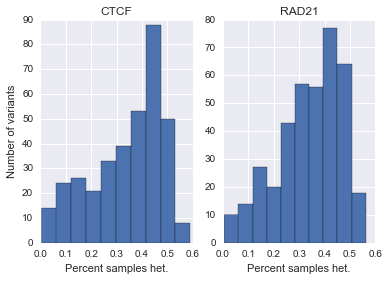

In [139]:
fig,axs = plt.subplots(1, 2)
ctcf_het.hist(ax=axs[0])
axs[0].set_xlabel('Percent samples het.')
axs[0].set_ylabel('Number of variants')
axs[0].set_title('CTCF')
rad21_het.hist(ax=axs[1])
axs[1].set_xlabel('Percent samples het.')
axs[1].set_title('RAD21');

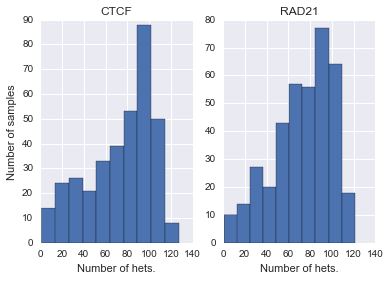

In [140]:
fig,axs = plt.subplots(1, 2)
(ctcf_genotypes == '01').sum(axis=1).hist(ax=axs[0])
axs[0].set_xlabel('Number of hets.')
axs[0].set_ylabel('Number of samples')
axs[0].set_title('CTCF')
(rad21_genotypes == '01').sum(axis=1).hist(ax=axs[1])
axs[1].set_xlabel('Number of hets.')
axs[1].set_title('RAD21');

In [141]:
fn = os.path.join(outdir, 'num_ctcf_het.tsv')
if not os.path.exists(fn):
    se = (ctcf_genotypes == '01').sum().sort_values(ascending=False)
    se.to_csv(fn, sep='\t')

In [142]:
fn = os.path.join(outdir, 'num_rad21_het.tsv')
if not os.path.exists(fn):
    se = (rad21_genotypes == '01').sum().sort_values(ascending=False)
    se.to_csv(fn, sep='\t')

##### ChIP-seq analysis

We did ChIP-seq for CTCF. Let's see if the peQTNs have evidence of allelic imbalance.

In [565]:
# Make ChIP-seq metadata table
exp = ['2433edfc-9dc1-432b-8267-2319f218cf18', 'fdd0575a-4d53-4d02-968c-9c87adc198aa',
        '32764cbc-41a2-4b30-9936-329672caf807', '7e43459d-f07f-49d3-a157-c527dda007e7',
        '2baa401f-b182-43bb-8669-4a4fe69eacce',]
subj = ['5d86bbdd-4854-449f-b99d-0d04d0ce4ee8', '59ba8d64-a92b-4ae2-bcb4-847de2fdf1dd',
        'eb79f47b-d933-4144-8d61-83104493418e', '56f0f073-725f-4cec-b8cb-db6ad0dc2ac0',
        '9603be9a-f146-4fc5-bf36-c84fac189b0a']
chip_seq_meta = pd.DataFrame([subj], columns=exp, index=['subject_id']).T
chip_seq_meta['target'] = 'CTCF'

chip_seq_meta['wgs_id'] = ''
for i in chip_seq_meta.index:
    t = wgs_meta[wgs_meta.subject_id == chip_seq_meta.ix[i, 'subject_id']]
    chip_seq_meta.ix[i, 'wgs_id'] = t.index[0]

In [144]:
# Make CTCF het files
het_vcf = os.path.join(private_outdir, 'ctcf_peqtns.vcf.gz')
vcf_path = '/frazer01/projects/CARDIPS/pipeline/WGS/mergedVCF/CARDIPS_201512.PASS.vcf.gz'
het_bed = cpb.bedtools.intervals_to_bed([':'.join(x.split(':')[0:2])[3:] for x in ctcf_genotypes.index]).sort()
c = 'bcftools view -Oz -R {} {} > {}'.format(het_bed.fn, vcf_path, het_vcf)
subprocess.check_call(c, shell=True)

for sample in set(chip_seq_meta.wgs_id):
    out_vcf = os.path.join(private_outdir, sample + '_ctcf_peqtns_hets.vcf')
    if not os.path.exists(out_vcf):
        c = ('bcftools view -Ou -s {} {} | '
             'bcftools view -Ou -g het | '
             'bcftools annotate --rename-chrs /repos/cardips-pipelines/RNA/chrom_conv.tsv -Ov > {}_temp.vcf'.format(
                sample, het_vcf, sample))
        subprocess.check_call(c, shell=True)
        c = ('perl ~/repos/cdeboever3/cdpipelines/cdpipelines/scripts/sortByRef.pl '
             '{0}_temp.vcf /publicdata/gatk_bundle_2.8/hg19/ucsc.hg19.fasta.fai > {0}_temp_sorted.vcf'.format(sample))
        subprocess.check_call(c, shell=True)
        c = 'grep -v ^\\# {0}_temp_sorted.vcf | uniq > {0}_temp_body.vcf'.format(sample)
        subprocess.check_call(c, shell=True)
        c = 'grep ^\\# {0}_temp_sorted.vcf | uniq > {0}_temp_header.vcf'.format(sample)
        subprocess.check_call(c, shell=True)
        c = 'cat {0}_temp_header.vcf {0}_temp_body.vcf > {1}'.format(sample, out_vcf)
        subprocess.check_call(c, shell=True)
        c = 'rm {0}_temp.vcf {0}_temp_sorted.vcf {0}_temp_body.vcf {0}_temp_header.vcf'.format(sample)
        subprocess.check_call(c, shell=True)

In [145]:
# Process bam files
for chip_sample in chip_seq_meta.index:
    sample = chip_seq_meta.ix[chip_sample, 'wgs_id']
    bam = '/projects/CARDIPS/pipeline/ChIPseq/sample/{0}/alignment/{0}.filtered.cordSorted.bam'.format(chip_sample)
    out_bam = os.path.join(private_outdir, chip_sample + '_reordered.bam')
    if not os.path.exists(out_bam):
        c = ('java -Xmx4g -jar '
             '-XX:ParallelGCThreads=1 '
             '-Djava.io.tmpdir={} '
             '-jar $picard AddOrReplaceReadGroups '
             'VALIDATION_STRINGENCY=SILENT '
             'I={} '
             'O={}_temp.bam '
             'RGID=4 '
             'RGLB=lib1 '
             'RGPL=illumina '
             'RGPU=unit1 '
             'RGSM=20'.format(
            os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name),
            bam,
            sample))
        subprocess.check_call(c, shell=True)
        c = ('java -Xmx4g -jar '
             '-XX:ParallelGCThreads=1 '
             '-Djava.io.tmpdir={} '
             '-jar $picard ReorderSam '
             'VALIDATION_STRINGENCY=SILENT '
             'I={}_temp.bam '
             'O={} '
             'REFERENCE=/publicdata/gatk_bundle_2.8/hg19/ucsc.hg19.fasta '
             .format(
                os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name),
                sample,
                out_bam,
            )
             )
        subprocess.check_call(c, shell=True)
        subprocess.check_call('rm {}_temp.bam'.format(sample), shell=True)
        subprocess.check_call('samtools index {}'.format(out_bam), shell=True)

In [146]:
for sample in chip_seq_meta.index:
    bam = os.path.join(private_outdir, sample + '_reordered.bam')
    if not os.path.exists(os.path.join(private_outdir, sample + '_ctcf_peqtns_het_counts.tsv')):
        c = ('java -Xmx3g -jar '
             '-XX:ParallelGCThreads=1 '
             '-Djava.io.tmpdir={} '
             '-jar $GATK '
             '-R /publicdata/gatk_bundle_2.8/hg19/ucsc.hg19.fasta '
             '-T ASEReadCounter '
             '-o {} '
             '-I {} '
             '-sites {} '
             '-overlap COUNT_FRAGMENTS_REQUIRE_SAME_BASE '
             '-U ALLOW_N_CIGAR_READS').format(
            os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name),
            os.path.join(private_outdir, sample + '_ctcf_peqtns_het_counts.tsv'),
            bam,
            os.path.join(private_outdir, chip_seq_meta.ix[sample, 'wgs_id'] + '_ctcf_peqtns_hets.vcf')
            )
        subprocess.check_call(c, shell=True)

In [571]:
fn = os.path.join(outdir, 'chip_seq_counts.pickle')
if not os.path.exists(fn):
    all_counts = dict()
    for sample in chip_seq_meta.index:
        counts = pd.read_table(os.path.join(private_outdir, '{}_ctcf_peqtns_het_counts.tsv'.format(sample)))
        counts['expectedRefFreq'] = 0.5
        counts = counts[counts.totalCount >= 8]
        pvals = []
        for i in counts.index:
            p = stats.binom_test(counts.ix[i, 'refCount'], counts.ix[i, 'totalCount'],
                                 counts.ix[i, 'expectedRefFreq'])
            pvals.append(p)
        counts['binomialPValue'] = pvals
        all_counts[sample] = counts
    with open(fn, 'w') as f:
        cPickle.dump(all_counts, f)
else:
    all_counts = cPickle.load(open(fn))

In [573]:
sig = []
not_sig = []
total = []
sig_vars = set()
for i in all_counts.keys():
    tdf = all_counts[i]
    vc = (tdf.binomialPValue < 0.005).value_counts()
    if True in vc.index:
        sig.append(vc[True])
    else:
        sig.append(0)
    not_sig.append(vc[False])
    total.append(tdf.shape[0])
    sig_vars |= set(tdf.contig + ':' + (tdf.position - 1).astype(str) + '-' + tdf.position.astype(str))

In [574]:
chip_sig = pd.DataFrame([sig, not_sig], columns=all_counts.keys(), index=['sig', 'not_sig']).T
chip_sig['total'] = chip_sig.sig + chip_sig.not_sig
chip_sig['percent'] = chip_sig.sig / chip_sig.total.astype(float)
chip_seq_meta = chip_seq_meta.join(chip_sig)

In [577]:
n = chip_sig.total.mean()
print('Tested {} heterozygous peQTNs predicted to disrupt CTCF on average per sample.'.format(n))

Tested 73.2 heterozygous peQTNs predicted to disrupt CTCF on average per sample.


In [578]:
n = chip_sig.percent.mean()
print('{:.1f}% heterozygous peQTNs predicted to disrupt CTCF had significant allelic bias per sample.'.format(n * 100))

55.5% heterozygous peQTNs predicted to disrupt CTCF had significant allelic bias per sample.


In [579]:
a = chip_sig.sig.sum()
b = chip_sig.total.sum()
print('{} of {} peQTNs tested were significant.'.format(a, b))

207 of 366 peQTNs tested were significant.


In [580]:
# Number of reads sequenced per sample
chip_seq_depth = []
for chip_sample in chip_seq_meta.index:
    sample = chip_seq_meta.ix[chip_sample, 'wgs_id']
    fn = '/projects/CARDIPS/pipeline/ChIPseq/sample/{0}/alignment/alignment.QCmatrix'.format(chip_sample)
    with open(fn) as f:
        chip_seq_depth.append(int(f.readline().split()[1]))
print('{:,} reads on average per sample.'.format(np.mean(chip_seq_depth)))

88,050,590.2 reads on average per sample.


#### Peaks

In [150]:
if not os.path.exists(os.path.join(outdir, 'ctcf_peaks.bed')):
    fns = []
    for i in chip_seq_meta.index:
        fns.append('/projects/CARDIPS/pipeline/ChIPseq/sample/{0}/peakCalling/macs2_callPeak_narrow_withCtrl'
                   '/macs2_callPeak_peaks.q001.collapse.narrowPeak'.format(i))

    peaks = cpb.bedtools.combine(fns)
    peaks.saveas(os.path.join(outdir, 'ctcf_peaks.bed'));

if not os.path.exists(os.path.join(outdir, 'ctcf_peaks.saf')):
    c = ('python /frazer01/home/cdeboever/repos/cdeboever3/cdpipelines/cdpipelines/convert_bed_to_saf.py '
         '{} {}'.format(os.path.join(outdir, 'ctcf_peaks.bed'), os.path.join(outdir, 'ctcf_peaks.saf')))
    subprocess.check_call(c, shell=True)

for i in chip_seq_meta.index: 
    bam = '/projects/CARDIPS/pipeline/ChIPseq/sample/{0}/alignment/{0}.filtered.querySorted.bam'.format(i)
    saf = os.path.join(outdir, 'ctcf_peaks.saf')
    out = os.path.join(outdir, '{}_featureCounts.tsv'.format(i))
    if not os.path.exists(out):
        c = 'featureCounts -p -T 8 --donotsort -F SAF -a {} -o {} {}'.format(saf, out, bam)
        subprocess.check_call(c, shell=True)

In [586]:
if not os.path.exists(os.path.join(outdir, 'ctcf_peak_counts.tsv')):
    ctcf_vars = cpb.bedtools.intervals_to_bed([':'.join(x.split(':')[0:2]) for x in ctcf_genotypes.index]).sort()
    res = peaks.intersect(ctcf_vars, wo=True, sorted=True)
    res = res.to_dataframe()
    fns = glob.glob(os.path.join(outdir, '*_featureCounts.tsv'))
    peak_counts = cpb.featureCounts.combine_counts(
        fns, define_sample_name=lambda x: os.path.split(x)[1].split('.')[0].split('_')[0])
    size_factors = cpb.analysis.deseq2_size_factors(peak_counts, chip_seq_meta, '~subject_id')
    peak_counts = peak_counts / size_factors
    peak_counts.to_csv(os.path.join(outdir, 'ctcf_peak_counts_all.tsv'), sep='\t')
    peak_counts = peak_counts.ix[set(res.chrom + ':' + res.start.astype(str) + '-' + res.end.astype(str))]
    peak_counts.to_csv(os.path.join(outdir, 'ctcf_peak_counts_all.tsv'), sep='\t')
else:
    peak_counts = pd.read_table(os.path.join(outdir, 'ctcf_peak_counts.tsv'), index_col=0)

In [265]:
fn = os.path.join(private_outdir, 'ctcf_genotypes_tri.tsv')
if not os.path.exists(fn):
    ctcf_genotypes_tri = ctcf_genotypes.copy(deep=True)
    ctcf_genotypes_tri = ctcf_genotypes_tri.replace('00', 0)
    ctcf_genotypes_tri = ctcf_genotypes_tri.replace('01', 1)
    ctcf_genotypes_tri = ctcf_genotypes_tri.replace('11', 2)
    ctcf_genotypes_tri.index = [':'.join(x.split(':')[0:2]) for x in ctcf_genotypes.index]
    ctcf_genotypes_tri['index'] = ctcf_genotypes_tri.index
    ctcf_genotypes_tri = ctcf_genotypes_tri.drop_duplicates(subset=['index'])
    ctcf_genotypes_tri = ctcf_genotypes_tri.drop('index', axis=1)
    ctcf_genotypes_tri = ctcf_genotypes_tri[chip_seq_meta.wgs_id.drop_duplicates()]

    cols = []
    for i in ctcf_genotypes_tri.columns:
        cols.append(chip_seq_meta[chip_seq_meta.wgs_id == i].index[0])

    ctcf_genotypes_tri.columns = cols
    ctcf_genotypes_tri = ctcf_genotypes_tri[peak_counts.columns]
    ctcf_genotypes_tri.to_csv(fn, sep='\t')
else: 
    ctcf_genotypes_tri = pd.read_table(fn, index_col=0)

In [266]:
var_to_peak = pd.Series((res.chrom + ':' + res.start.astype(str) + '-' + res.end.astype(str)).values,
                        index=(res.name + ':' + res.score.astype(str) + '-' + res.strand.astype(str)).values).drop_duplicates()

In [428]:
disrupt_sign = []
for i in var_to_peak.index:
    t = motif_d.ix[i].dropna()
    t = t[[x for x in t.index if 'CTCF' in x]]
    if (t > 0).value_counts().shape[0] == 1:
        disrupt_sign.append(sum(t > 0) / float(t.shape[0]) > 0.5)
disrupt_sign = pd.Series(dict(zip(var_to_peak.index, disrupt_sign)))

In [582]:
fn = os.path.join(outdir, 'ctcf_aggregate_counts.tsv')
if not os.path.exists(fn):
    genotypes = []
    counts = []
    for i in ctcf_genotypes_tri.index:
        if i in var_to_peak.index and i in sig_vars and i in disrupt_sign.index:
            if var_to_peak[i] in peak_counts.index:
                g = ctcf_genotypes_tri.ix[i]
                c = np.log10(peak_counts.ix[var_to_peak[i]] + 1)
                c = c - c.mean()
                c = c / c.std()
                c = list(c)
                if disrupt_sign[i] == False:
                    c.reverse()
                genotypes += list(g)
                counts += c
    agg_counts = pd.DataFrame({'genotypes':genotypes, 'counts':counts})
    agg_counts.to_csv(fn, '\t')
else:
    agg_counts = pd.read_table(fn, index_col=0)

In [583]:
agg_counts.genotypes.value_counts()

1    264
0    205
2     86
Name: genotypes, dtype: int64

In [445]:
n = len(var_to_peak.index & set(sig_vars) & disrupt_sign.index)
print('{} sites can be used to check direction of effect.'.format(n))

111 sites can be used to check direction of effect.


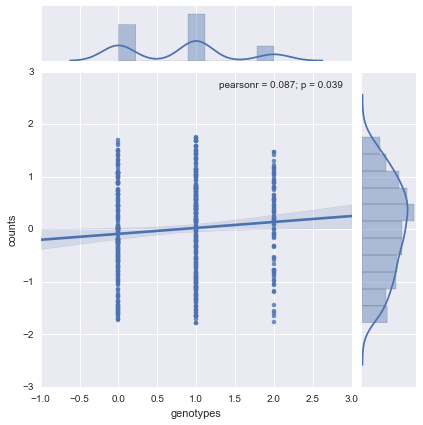

In [435]:
sns.jointplot(x='genotypes', y='counts', data=agg_counts, kind='reg');

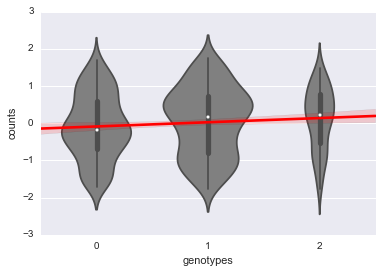

In [294]:
plt.figure()
ax = sns.violinplot(x='genotypes', y='counts', data=agg_counts, color='grey',
                order=[0, 1, 2], scale='count')
sns.regplot(x='genotypes', y='counts', data=tdf, scatter=False, color='red');

In [319]:
for k in all_counts.keys():
    all_counts[k]['sample'] = k

In [320]:
ac = pd.concat(all_counts.values())

In [325]:
ac[ac.binomialPValue < 0.05].shape[0] / float(ac.shape[0])

0.5104602510460251

In [326]:
ac_sig = ac[ac.binomialPValue < 0.05]

### 3D interactions

In [456]:
fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing', 'interactions.tsv')
interactions = pd.read_table(fn)

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing', 
                  'gene_to_containing_interactions.pickle')
gene_to_containing_interactions = cPickle.load(open(fn))

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_to_exon_gene.pickle')
chia_to_exon_gene = cPickle.load(open(fn))
fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_to_promoter_gene.pickle')
chia_to_promoter_gene = cPickle.load(open(fn))

fn = os.path.join(ciepy.root, 'output', 'ji_et_al_2015_processing',
                  'chia_peaks.bed')
chia_peaks = pbt.BedTool(fn)

In [457]:
s = '\n'.join(gene_variants_f.location.apply(
        lambda x: '\t'.join(cpb.general.parse_region(x)))) + '\n'
var_bt = pbt.BedTool(s, from_string=True)
var_bt = var_bt.sort()
res = var_bt.intersect(chia_peaks, wo=True, sorted=True)
d = {}
for r in res:
    ind = '{}:{}-{}'.format(r.chrom, r.start, r.end)
    d[ind] = d.get(ind, set()) | set(['{}:{}-{}'.format(*r.fields[-4:-1])])
se = pd.Series(d)
    
gene_variants_f = gene_variants_f.merge(pd.DataFrame({'chia_peaks': se}), 
                                      left_on='location', right_index=True, how='left')

In [458]:
s = '\n'.join(lead_variants_single_f.location.apply(
        lambda x: '\t'.join(cpb.general.parse_region(x)))) + '\n'
var_bt = pbt.BedTool(s, from_string=True)
var_bt = var_bt.sort()
res = var_bt.intersect(chia_peaks, wo=True, sorted=True)
d = {}
for r in res:
    ind = '{}:{}-{}'.format(r.chrom, r.start, r.end)
    d[ind] = d.get(ind, set()) | set(['{}:{}-{}'.format(*r.fields[-4:-1])])
se = pd.Series(d)
    
lead_variants_single_f = lead_variants_single_f.merge(pd.DataFrame({'chia_peaks': se}), 
                                                  left_on='location', right_index=True, how='left')

In [459]:
def get_other_end(peaks):
    if type(peaks) is set:
        other_ends = []
        for p in peaks:
            other_ends += list(interactions.ix[interactions.peak1 == p, 'peak2'])
            other_ends += list(interactions.ix[interactions.peak2 == p, 'peak1'])
        return set(other_ends)
    else:
        return np.nan
    
def get_promoter_gene(peaks):
    if type(peaks) is set:
        peaks = peaks & set(chia_to_promoter_gene.index)
        genes = []
        for p in peaks:
            genes += list(chia_to_promoter_gene[p])
        out = set(genes)
        if len(out) == 0:
            return np.nan
        else:
            return out
    else:
        return np.nan

In [460]:
gene_variants_f['chia_interaction_peak'] = gene_variants_f.chia_peaks.apply(lambda x: get_other_end(x))
lead_variants_single_f['chia_interaction_peak'] = lead_variants_single_f.chia_peaks.apply(lambda x: get_other_end(x))

In [461]:
gene_variants_f['chia_interaction_promoter_gene'] = \
    gene_variants_f.chia_interaction_peak.apply(lambda x: get_promoter_gene(x))
lead_variants_single_f['chia_interaction_promoter_gene'] = \
    lead_variants_single_f.chia_interaction_peak.apply(lambda x: get_promoter_gene(x))

In [462]:
gene_variants_f['interacts_with_promoter'] = np.nan
t = gene_variants_f[gene_variants_f.chia_interaction_promoter_gene.isnull() == False]
se = t.apply(lambda x: x['gene_id'] in x['chia_interaction_promoter_gene'], axis=1)
gene_variants_f.ix[se.index, 'interacts_with_promoter'] = se

In [463]:
lead_variants_single_f['interacts_with_promoter'] = np.nan
t = lead_variants_single_f[lead_variants_single_f.chia_interaction_promoter_gene.isnull() == False]
se = t.apply(lambda x: x['gene_id'] in x['chia_interaction_promoter_gene'], axis=1)
lead_variants_single_f.ix[se.index, 'interacts_with_promoter'] = se

In [464]:
shared = set(lead_variants_single_f.index) & set(gene_variants_f.index)

In [465]:
a = lead_variants_single_f.interacts_with_promoter.sum()
b = gene_variants_f.interacts_with_promoter.sum()
c = len(set(lead_variants_single_f[lead_variants_single_f.interacts_with_promoter == True].index) 
        & set(gene_variants_f[gene_variants_f.interacts_with_promoter == True].index))
print('{} lead variants and {} putative eQTNs ({} shared) '
      'interact with promoters.'.format(a, b, c))

71 lead variants and 154 putative eQTNs (19 shared) interact with promoters.


In [466]:
lead_interact = lead_variants_single_f.drop(shared).interacts_with_promoter.sum()
lead_no_interact = lead_variants_single_f.drop(shared).shape[0] - lead_interact
put_interact = gene_variants_f.drop(shared).interacts_with_promoter.sum()
put_no_interact = gene_variants_f.drop(shared).shape[0] - put_interact
stats.fisher_exact([[put_interact, put_no_interact], [lead_interact, lead_no_interact]])

(4.0348059198865647, 1.9501785416492163e-19)

In [467]:
sum(gene_variants_f[gene_variants_f.interacts_with_promoter == True].tss_dist_abs > 20000)

46

In [468]:
sum(lead_variants_single_f[lead_variants_single_f.interacts_with_promoter == True].tss_dist_abs > 20000)

13

In [469]:
sum(gene_variants_f.tss_dist_abs > 20000)

1799

In [472]:
gene_variants_f.tss_dist_abs.median()

15029.0

In [473]:
lead_variants_single_f.tss_dist_abs.median()

15300.5

In [493]:
ttt = lead_variants_single_f[lead_variants_single_f.interacts_with_promoter == True]

In [499]:
ttt.ix['chr17:2296013-2296014:ENSG00000070444.10']

chrom                                                chr17
start                                              2296013
end                                                2296014
marker_id                         17:2296014_T/C_rs2447091
ns                                                     215
ac                                                     168
callrate                                                 1
genocnt                                          73/116/26
maf                                                 0.3907
stat                                               -5.2045
pvalue                                           4.583e-07
beta                                               -0.5136
sebeta                                             0.09869
r2                                                  0.1133
gene_id                                 ENSG00000070444.10
ref                                                      T
alt                                                     

In [505]:
interactions['distance'] = (interactions.end1 - interactions.start1) / 2. - (interactions.end2 - interactions.start2) / 2.
interactions['distance'] = interactions.distance.abs()

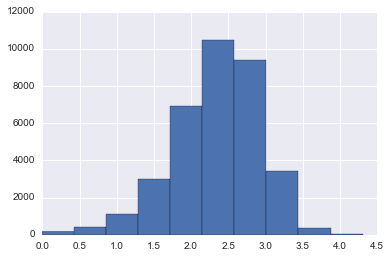

In [509]:
np.log10(interactions.distance + 1).hist()

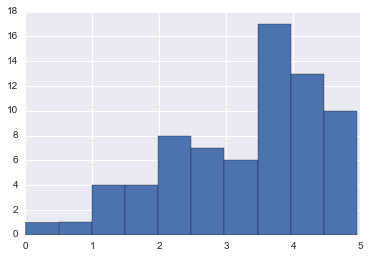

In [485]:
np.log10(lead_variants_single_f[lead_variants_single_f.interacts_with_promoter == True].tss_dist_abs + 1).hist()

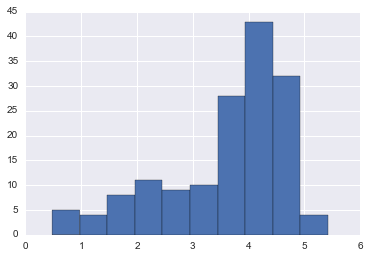

In [486]:
np.log10(gene_variants_f[gene_variants_f.interacts_with_promoter == True].tss_dist_abs + 1).hist()

In [519]:
mi = interactions.apply(
    lambda x: min(x['start1'], x['start2']), axis=1)
ma = interactions.apply(
    lambda x: max(x['end1'], x['end2']), axis=1)
se = ma - mi
# np.log10(se.abs()).hist(bins=50)
# plt.ylabel('Number of loops')
# plt.xlabel('$log_{10}$ size in bp')
# plt.title('Median: {}'.format(se.median()));

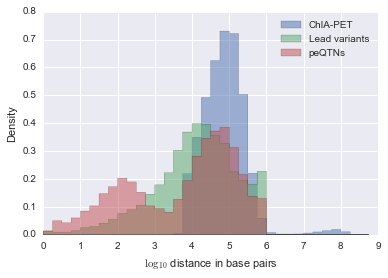

In [533]:
np.log10(se.abs()).hist(normed=True, alpha=0.5, label='ChIA-PET', bins=np.arange(0, 9, 0.25), histtype='stepfilled')
np.log10(lead_variants_single_f.tss_dist_abs + 1).hist(normed=True, alpha=0.5, label='Lead variants', bins=np.arange(0, 9, 0.25), histtype='stepfilled')
np.log10(gene_variants_f.tss_dist_abs + 1).hist(normed=True, alpha=0.5, label='peQTNs', bins=np.arange(0, 9, 0.25), histtype='stepfilled')
plt.legend()
plt.xlabel('$\log_{10}$ distance in base pairs')
plt.ylabel('Density')

In [599]:
fn = os.path.join(outdir, 'tss_distance_kde.tsv')
if not os.path.exists(fn):
    pdfs = pd.DataFrame(index=np.arange(0, 9 + 0.1, 0.1))
    density = scipy.stats.gaussian_kde(np.log10(se.abs()))
    pdfs['ChIA-PET interactions'] = density(pdfs.index)
    density = scipy.stats.gaussian_kde(np.log10(lead_variants_single_f.tss_dist_abs + 1))
    pdfs['Lead variants'] = density(pdfs.index)
    density = scipy.stats.gaussian_kde(np.log10(gene_variants_f.tss_dist_abs + 1))
    pdfs['peQTNs'] = density(pdfs.index)
    pdfs.to_csv(fn, sep='\t')
else:
    pdfs = pd.read_table(fn, index_col=0)

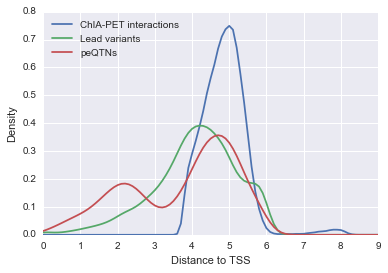

In [600]:
pdfs.plot()
plt.xlabel('Distance to TSS')
plt.ylabel('Density');

### Motif Similarity

In [ ]:
s = cpb.general.read_gzipped_text_url('http://compbio.mit.edu/encode-motifs/motifs-sim.txt.gz')
lines = s.strip().split('\n')
lines = [x.split('\t') for x in lines]
vals = [x[1:] for x in lines[1:]]
index = [x[0] for x in lines][1:]
header = lines[0][1:]
motif_sim = pd.DataFrame(vals, index=index, columns=header)
motif_sim = motif_sim.astype(float)

In [ ]:
t = motif_sim.ix[motif_info.index, motif_info.index]

In [ ]:
sns.clustermap(t, xticklabels=[], yticklabels=[]);

In [ ]:
sns.heatmap(motif_sim, xticklabels=[], yticklabels=[]);

In [ ]:
tf_overlap.ix[gene_variants_f.location.drop_duplicates()].sum(axis=1).value_counts().sort_index().plot(kind='bar')

In [ ]:
motif_disrupt.ix[gene_variants_f.location.drop_duplicates()].sum(axis=1).value_counts().sort_index().plot(kind='bar')

In [ ]:
num_tf_motifs = []
for i in gene_variants_f.location.drop_duplicates():
    se = motif_disrupt.ix[i]
    num_tf_motifs.append(len(set([x.split('_')[0] for x in se[se].index])))
pd.Series(num_tf_motifs).value_counts().sort_index().plot(kind='bar')

In [ ]:
for i in gene_variants_f.location.drop_duplicates()[0:5]:
    se = motif_disrupt.ix[i]
    df = motif_sim.ix[se[se].index]
    df = df > 0.75
    print('Disrupts motifs: {}'.format(', '.join(list(se[se].index))))
    print('These motifs are similar to known motifs for: {}'.format(
            ', '.join(list(set([x.split('_')[0] for x in df.sum()[df.sum() > 0].index if 'disc' not in x])))))
    print('These TFs are not expected: {}'.format(
        ', '.join(set([x.split('_')[0] for x in df.sum()[df.sum() > 0].index if 'disc' not in x]) - 
                              set([x.split('_')[0] for x in se[se].index]))))
    print('----------------------------------------------------------------------------------------------------')

In [ ]:
num_sim_motifs = []
for i in gene_variants_f.location.drop_duplicates():
    se = motif_disrupt.ix[i]
    df = motif_sim.ix[se[se].index]
    df = df > 0.75
    num_sim_motifs.append(len(set([x.split('_')[0] for x in df.sum()[df.sum() > 0].index if 'disc' not in x]) - 
                              set([x.split('_')[0] for x in se[se].index])))

pd.Series(num_sim_motifs).value_counts().sort_index().plot(kind='bar')

In [ ]:
t = []
for a in gene_variants_f.index:
    i = gene_variants_f.ix[a, 'location']
    se = motif_disrupt.ix[i]
    se = se[se]
    se = se[[x for x in se.index if 'known' in x]]
    s = set(motif_info.ix[se.index, 'target'])
    if sum(tf_overlap.ix[i, s] > 0):
        t.append(a)
n = len(set(gene_variants_f.ix[t, 'gene_id'])) / float(len(set(gene_variants_f['gene_id'])))
print('{:.2f}% of eGenes with a peQTN have at least one peQTN that disrupts'
      ' a known motif for the TF that it overlaps.'.format(n * 100))

In [ ]:
a = sum(pd.Series(num_sim_motifs) > 0)
b = len(num_sim_motifs)
print('{:,} of {:,} ({:.2f}%) peQTNs disrupt a motif that is '
      'similar to a known motif for a different TF (e.g. the variant '
      'does not overlap a peak for the other TF)'.format(a, b, a / float(b) * 100))

In [ ]:
motif_sim.ix['ETV6_1'].hist()